# NN track reco on synthetic data

The data input and NN architecture are inspired from the HEPTrkX LSTM example.
The input here is including all straws for each event, which may be inefficient (at least for training) and alternatives should be explored.  
The input is per-seed, where each track can have multiple seeds.  

This script is working on synthetic data (under development).  

Update 9/27: This script uses real seeds.

## Notes on current status


### Summary

The NN is based on 2 LSTM layers. Separate NNs are trained for each seed region.  
We are using an iterative approach, where the output of the NN for all seeds is processed, to merge hits and seeds into tracks. (note that we are still using truth information for the seeds)  
At each iteration we aim to fully use the information from the NN processing, either by assigning hits/seeds of high certainty, or removing hits of very low likelihood to belong to a given track.  
After a few iterations (up to ~10 for complicated events) we stop with the existing found tracks, and disambiguate  remaining multiply-assigned hits.  

Overall, this is a combination of a NN with an algorithmic assignment step. Recursiveness and updating based on available information make this similar to a Kalman filter.  
Note that a downside of this approach is that it is too sequential and therefore cannot be well parallelized.


### Pseudo-data application
The LSTM-based NN does pretty good with the realistic geometry and some difficult events in the pseudo-dataset. Very good performance demonstrated. 


### Synthetic data application  
The pre-trained model loses a significant portion of its accuracy on the synthetic events. In all likelihood this comes from working with real 3D geometry, which due to straw orientation appears different when projected on 2D.  
With some quick re-training on few synthetic events we recover very good performance, but apparently we will need to train on the synthetic events (or, look into creating 3D pseudo-tracks).



### Improvements needed
* Develop seed finder module.
    * Then adapt the track finding to work with not-necessarily-pure seeds.
    * Further work: develop module for reconstruction of track parameters, working on the output of track finding.
* Add seeds as categorical variable. There are still a few cases where the seed hits are not selected, in difficult cases.
    * Although stacking seems to be generally an acceptable method, see for example: https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#create_a_tfdatadataset
    * OTOH, for seeds a separate input may make sense. See eg: https://www.tensorflow.org/guide/keras/rnn#rnns_with_listdict_inputs_or_nested_inputs
* Prepare to add another feature variable for hit time. That should add more discrimination in high occupancy, and better track separation overall.
    * Stacking the input may be fine for this one too, but that will come with another increase in # of parameters. Lets develop some performance measures to understand tradeoffs. 
* See into improving training by adding weights to events, eg according to their number of hits.
* Add extra NN, each specializing in seeds from beginning/middle/end of the detector. That should improve performance for seeds late in the detector.
    * Done


## Define the Detector class

In [1]:
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

In [2]:
class Detector():
    """
    Simulate a 2D rectangular straw setup.
    Made of successive modules, each one consisting of U/V double layers of straws.
    """
    n_modules=8 ## number of modules, each with 4 layers of straws
    n_layersPerModule=4
    n_layers = n_modules*n_layersPerModule
    n_straws=32
    
    straw_radius=0.25 # [cm]
    straw_distance=1.2 # distance between neighboring straw centers in same layer [cm]
    UV_distance=1.7   # distance between successive U/V submodules [cm]
    module_distance=7   # distance between successive modules [cm]
    yOffset_PerModule = 5 # y-offset per module, to allow for inward bend of tracks

    module_length = (n_layersPerModule/2)*straw_distance + UV_distance + 2*straw_radius
    length=n_modules*module_length + (n_modules-1)*module_distance
    width=n_straws*straw_distance+2*straw_radius
    
    ## Occupancy characteristics
    avg_tracks=2 ## avg number of tracks per event
    max_tracks=3 ## max number of tracks allowed per event

    
    layers=np.zeros(n_layers)
    straws=np.zeros(n_straws)
    x=np.zeros(n_layers)
    y=np.zeros((n_layers, n_straws))
    
    def make_straws(self):
        ## make straws, based on their locations as found in:
        ## https://cdcvs.fnal.gov/redmine/projects/gm2dqm/repository/revisions/develop/entry/node/tracker/public/tracker/scripts/trackerTracks.js
        ## returns the x,y (length,width) vectors of straw locations
        UView = {
            'x': [-12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -12.696, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, -7.5, 121.6674, 121.6677, 121.6679, 121.6671, 121.6673, 121.6677, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 121.667, 126.8635, 126.8638, 126.863, 126.8632, 126.8634, 126.8637, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 126.863, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 256.021, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 261.217, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 390.375, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 395.571, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 524.725, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 529.921, 659.065,  659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 659.065, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 664.261, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 793.407, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 798.603, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 927.737, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933, 932.933],
            'y': [-64.3105, -58.2588, -52.207, -46.1552, -40.1034, -34.0517, -27.9999, -21.9481, -15.8963, -9.84457, -3.7928, 2.25898, 8.31075, 14.3625, 20.4143, 26.4661, 32.5178, 38.5696, 44.6214, 50.6732, 56.7249, 62.7767, 68.8285, 74.8803, 80.932, 86.9838, 93.0356, 99.0874, 105.139, 111.191, 117.243, 123.294, -61.2846, -55.2329, -49.1811, -43.1293, -37.0775, -31.0258, -24.974, -18.9222, -12.8704, -6.81867, -0.766897, 5.28488, 11.3367, 17.3884, 23.4402, 29.492, 35.5437, 41.5955, 47.6473, 53.6991, 59.7508, 65.8026, 71.8544, 77.9062, 83.9579, 90.0097, 96.0615, 102.113, 108.165, 114.217, 120.269, 126.32, -34.5014, -28.4497, -22.3979, -16.3461, -10.2943, -4.24257, 1.80921, 7.86098, 13.9128, 19.9645, 26.0163, 32.0681, 38.1198, 44.1716, 50.2234, 56.2752, 62.3269, 68.3787, 74.4305, 80.4823, 86.534, 92.5858, 98.6376, 104.689, 110.741, 116.793, 122.845, 128.896, 134.948, 141, 147.052, 153.104, -31.4755, -25.4238, -19.372, -13.3202, -7.26844, -1.21667, 4.83511, 10.8869, 16.9387, 22.9904, 29.0422, 35.094, 41.1457, 47.1975, 53.2493, 59.3011, 65.3528, 71.4046, 77.4564, 83.5082, 89.5599, 95.6117, 101.663, 107.715, 113.767, 119.819, 125.871, 131.922, 137.974, 144.026, 150.078, 156.129, -7.35165, -1.29987, 4.7519, 10.8037, 16.8554, 22.9072, 28.959, 35.0108, 41.0625, 47.1143, 53.1661, 59.2179, 65.2696, 71.3214, 77.3732, 83.425, 89.4767, 95.5285, 101.58, 107.632, 113.684, 119.736, 125.787, 131.839, 137.891, 143.943, 149.994, 156.046, 162.098, 168.15, 174.202, 180.253, -4.32575, 1.72603, 7.7778, 13.8296, 19.8813, 25.9331, 31.9849, 38.0367, 44.0884, 50.1402, 56.192, 62.2438, 68.2955, 74.3473, 80.3991, 86.4509, 92.5026, 98.5544, 104.606, 110.658, 116.71, 122.762, 128.813, 134.865, 140.917, 146.969, 153.02, 159.072, 165.124, 171.176, 177.227, 183.279, 17.1099, 23.1617, 29.2135, 35.2652, 41.317, 47.3688, 53.4206, 59.4723, 65.5241, 71.5759, 77.6277, 83.6794, 89.7312, 95.783, 101.835, 107.887, 113.938, 119.99, 126.042, 132.094, 138.145, 144.197, 150.249, 156.301, 162.352, 168.404, 174.456, 180.508, 186.56, 192.611, 198.663, 204.715, 20.1358, 26.1876, 32.2394, 38.2911, 44.3429, 50.3947, 56.4465, 62.4982, 68.55, 74.6018, 80.6536, 86.7053, 92.7571, 98.8089, 104.861, 110.912, 116.964, 123.016, 129.068, 135.12, 141.171, 147.223, 153.275, 159.327, 165.378, 171.43, 177.482, 183.534, 189.585, 195.637, 201.689, 207.741, 38.8201, 44.8719, 50.9237, 56.9754, 63.0272, 69.079, 75.1308, 81.1825, 87.2343, 93.2861, 99.3379, 105.39, 111.441, 117.493, 123.545, 129.597, 135.649, 141.7, 147.752, 153.804, 159.856, 165.907, 171.959, 178.011, 184.063, 190.114, 196.166, 202.218, 208.27, 214.322, 220.373, 226.425, 41.846, 47.8978, 53.9496, 60.0013, 66.0531, 72.1049, 78.1567, 84.2084, 90.2602, 96.312, 102.364, 108.416, 114.467, 120.519, 126.571, 132.623, 138.674, 144.726, 150.778, 156.83, 162.881, 168.933, 174.985, 181.037, 187.089, 193.14, 199.192, 205.244, 211.296, 217.347, 223.399, 229.451, 57.9122, 63.964, 70.0158, 76.0675, 82.1193, 88.1711, 94.2229, 100.275, 106.326, 112.378, 118.43, 124.482, 130.534, 136.585, 142.637, 148.689, 154.741, 160.792, 166.844, 172.896, 178.948, 184.999, 191.051, 197.103, 203.155, 209.207, 215.258, 221.31, 227.362, 233.414, 239.465, 245.517, 60.9381, 66.9899, 73.0417, 79.0934, 85.1452, 91.197, 97.2488, 103.301, 109.352, 115.404, 121.456, 127.508, 133.559, 139.611, 145.663, 151.715, 157.767, 163.818, 169.87, 175.922, 181.974, 188.025, 194.077, 200.129, 206.181, 212.232, 218.284, 224.336, 230.388, 236.44, 242.491, 248.543, 74.3793, 80.4311, 86.4828, 92.5346, 98.5864, 104.638, 110.69, 116.742, 122.793, 128.845, 134.897, 140.949, 147.001, 153.052, 159.104, 165.156, 171.208, 177.259, 183.311, 189.363, 195.415, 201.467, 207.518, 213.57, 219.622, 225.674, 231.725, 237.777, 243.829, 249.881, 255.932, 261.984, 77.4052, 83.457, 89.5087, 95.5605, 101.612, 107.664, 113.716, 119.768, 125.819, 131.871, 137.923, 143.975, 150.026, 156.078, 162.13, 168.182, 174.234, 180.285, 186.337, 192.389, 198.441, 204.492, 210.544, 216.596, 222.648, 228.7, 234.751, 240.803, 246.855, 252.907, 258.958, 265.01, 88.2379, 94.2896, 100.341, 106.393, 112.445, 118.497, 124.549, 130.6, 136.652, 142.704, 148.756, 154.807, 160.859, 166.911, 172.963, 179.014, 185.066, 191.118, 197.17, 203.222, 209.273, 215.325, 221.377, 227.429, 233.48, 239.532, 245.584, 251.636, 257.688, 263.739, 269.791, 275.843, 91.2638, 97.3155, 103.367, 109.419, 115.471, 121.523, 127.574, 133.626, 139.678, 145.73, 151.782, 157.833, 163.885, 169.937, 175.989, 182.04, 188.092, 194.144, 200.196, 206.247, 212.299, 218.351, 224.403, 230.455, 236.506, 242.558, 248.61, 254.662, 260.713, 266.765, 272.817, 278.869]
        }
        VView = {
            'x': [7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 12.696, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 141.863, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 147.059, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 276.217, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 281.413, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 410.571, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 415.767, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 544.921, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 550.117, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 679.261, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 684.457, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 813.603, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 818.799, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 947.933, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129, 953.129],
            'y': [-60.9556, -54.9038, -48.852, -42.8002, -36.7485, -30.6967, -24.6449, -18.5931, -12.5414, -6.4896, -0.437828, 5.61395, 11.6657, 17.7175, 23.7693, 29.821, 35.8728, 41.9246, 47.9764, 54.0281, 60.0799, 66.1317, 72.1835, 78.2352, 84.287, 90.3388, 96.3906, 102.442, 108.494, 114.546, 120.598, 126.649, -63.9815, -57.9297, -51.8779, -45.8261, -39.7744, -33.7226, -27.6708, -21.619, -15.5673, -9.5155, -3.46373, 2.58805, 8.63982, 14.6916, 20.7434, 26.7951, 32.8469, 38.8987, 44.9505, 51.0022, 57.054, 63.1058, 69.1576, 75.2093, 81.2611, 87.3129, 93.3647, 99.4164, 105.468, 111.52, 117.572, 123.624, -31.1465, -25.0947, -19.0429, -12.9911, -6.93937, -0.887599, 5.16417, 11.2159, 17.2677, 23.3195, 29.3713, 35.423, 41.4748, 47.5266, 53.5784, 59.6301, 65.6819, 71.7337, 77.7855, 83.8372, 89.889, 95.9408, 101.993, 108.044, 114.096, 120.148, 126.2, 132.251, 138.303, 144.355, 150.407, 156.459, -34.1724, -28.1206, -22.0688, -16.017, -9.96527, -3.9135, 2.13827, 8.19005, 14.2418, 20.2936, 26.3454, 32.3971, 38.4489, 44.5007, 50.5525, 56.6042, 62.656, 68.7078, 74.7596, 80.8113, 86.8631, 92.9149, 98.9667, 105.018, 111.07, 117.122, 123.174, 129.226, 135.277, 141.329, 147.381, 153.433, -3.99668, 2.05509, 8.10687, 14.1586, 20.2104, 26.2622, 32.314, 38.3657, 44.4175, 50.4693, 56.5211, 62.5728, 68.6246, 74.6764, 80.7282, 86.7799, 92.8317, 98.8835, 104.935, 110.987, 117.039, 123.091, 129.142, 135.194, 141.246, 147.298, 153.349, 159.401, 165.453, 171.505, 177.557, 183.608, -7.02258, -0.970805, 5.08097, 11.1327, 17.1845, 23.2363, 29.2881, 35.3398, 41.3916, 47.4434, 53.4952, 59.5469, 65.5987, 71.6505, 77.7023, 83.754, 89.8058, 95.8576, 101.909, 107.961, 114.013, 120.065, 126.116, 132.168, 138.22, 144.272, 150.324, 156.375, 162.427, 168.479, 174.531, 180.582, 20.4649, 26.5167, 32.5684, 38.6202, 44.672, 50.7238, 56.7755, 62.8273, 68.8791, 74.9309, 80.9826, 87.0344, 93.0862, 99.138, 105.19, 111.242, 117.293, 123.345, 129.397, 135.449, 141.5, 147.552, 153.604, 159.656, 165.707, 171.759, 177.811, 183.863, 189.915, 195.966, 202.018, 208.07, 17.439, 23.4908, 29.5425, 35.5943, 41.6461, 47.6979, 53.7496, 59.8014, 65.8532, 71.905, 77.9567, 84.0085, 90.0603, 96.1121, 102.164, 108.216, 114.267, 120.319, 126.371, 132.423, 138.474, 144.526, 150.578, 156.63, 162.682, 168.733, 174.785, 180.837, 186.889, 192.94, 198.992, 205.044, 42.1751, 48.2269, 54.2786, 60.3304, 66.3822, 72.434, 78.4857, 84.5375, 90.5893, 96.6411, 102.693, 108.745, 114.796, 120.848, 126.9, 132.952, 139.003, 145.055, 151.107, 157.159, 163.211, 169.262, 175.314, 181.366, 187.418, 193.469, 199.521, 205.573, 211.625, 217.677, 223.728, 229.78, 39.1492, 45.201, 51.2527, 57.3045, 63.3563, 69.4081, 75.4598, 81.5116, 87.5634, 93.6152, 99.6669, 105.719, 111.77, 117.822, 123.874, 129.926, 135.978, 142.029, 148.081, 154.133, 160.185, 166.236, 172.288, 178.34, 184.392, 190.444, 196.495, 202.547, 208.599, 214.651, 220.702, 226.754, 61.2672, 67.319, 73.3707, 79.4225, 85.4743, 91.5261, 97.5778, 103.63, 109.681, 115.733, 121.785, 127.837, 133.888, 139.94, 145.992, 152.044, 158.096, 164.147, 170.199, 176.251, 182.303, 188.354, 194.406, 200.458, 206.51, 212.562, 218.613, 224.665, 230.717, 236.769, 242.82, 248.872, 58.2413, 64.2931, 70.3448, 76.3966, 82.4484, 88.5002, 94.5519, 100.604, 106.655, 112.707, 118.759, 124.811, 130.863, 136.914, 142.966, 149.018, 155.07, 161.121, 167.173, 173.225, 179.277, 185.329, 191.38, 197.432, 203.484, 209.536, 215.587, 221.639, 227.691, 233.743, 239.795, 245.846, 77.7342, 83.786, 89.8378, 95.8896, 101.941, 107.993, 114.045, 120.097, 126.148, 132.2, 138.252, 144.304, 150.356, 156.407, 162.459, 168.511, 174.563, 180.614, 186.666, 192.718, 198.77, 204.821, 210.873, 216.925, 222.977, 229.029, 235.08, 241.132, 247.184, 253.236, 259.287, 265.339, 74.7083, 80.7601, 86.8119, 92.8637, 98.9154, 104.967, 111.019, 117.071, 123.123, 129.174, 135.226, 141.278, 147.33, 153.381, 159.433, 165.485, 171.537, 177.589, 183.64, 189.692, 195.744, 201.796, 207.847, 213.899, 219.951, 226.003, 232.054, 238.106, 244.158, 250.21, 256.262, 262.31, 91.5928, 97.6446, 103.696, 109.748, 115.8, 121.852, 127.903, 133.955, 140.007, 146.059, 152.111, 158.162, 164.214, 170.266, 176.318, 182.369, 188.421, 194.473, 200.525, 206.577, 212.628, 218.68, 224.732, 230.784, 236.835, 242.887, 248.939, 254.991, 261.043, 267.094, 273.146, 279.198, 88.5669, 94.6187, 100.67, 106.722, 112.774, 118.826, 124.878, 130.929, 136.981, 143.033, 149.085, 155.136, 161.188, 167.24, 173.292, 179.344, 185.395, 191.447, 197.499, 203.551, 209.602, 215.654, 221.706, 227.758, 233.81, 239.861, 245.913, 251.965, 258.017, 264.068, 270.12, 276.172],
        }
        ## above are in mm, turn to cm
        for dim in ['x','y']:
            for i in range(len(UView[dim])):
                UView[dim][i]/=10
                VView[dim][i]/=10
        ## shift vertically to 0, to avoid negative numbers
        miny = min(UView['y'])
        for i in range(len(UView['y'])):
            UView['y'][i]-=miny
            VView['y'][i]-=miny
        
        for i_module in range(self.n_modules):
            for i_layerU in range(2):        
                layer = i_module*self.n_layersPerModule + i_layerU
                self.layers[layer]=layer
                i_straw0 = self.n_straws*(2*i_module+i_layerU)
                layer_x = UView['x'][i_straw0]
                self.x[layer] = layer_x
                for i_straw in range(self.n_straws):
                    self.y[layer][i_straw] = UView['y'][i_straw0+i_straw]
            for i_layerV in range(2):        
                layer = i_module*self.n_layersPerModule + 2+i_layerV
                self.layers[layer]=layer
                i_straw0 = self.n_straws*(2*i_module+i_layerV)
                layer_x = VView['x'][i_straw0]
                self.x[layer] = layer_x
                for i_straw in range(self.n_straws):
                    self.y[layer][i_straw] = VView['y'][i_straw0+i_straw]

        self.length = VView['x'][-1] - UView['x'][0]
        self.width  = max(VView['y']) - min(VView['y'])
    
    def make_straws_guesst(self):
        ## make straws, based on a guesstimate of their realtive distances.
        ## returns the x,y (length,width) vectors of straw locations
        for i_module in range(self.n_modules):
            for i_layer in range(self.n_layersPerModule):
                layer = i_module*self.n_layersPerModule + i_layer
                self.layers[layer]=layer
                layer_x = i_module*self.module_length + self.straw_radius
                if i_module>0: layer_x += i_module*self.module_distance
                if i_layer>=1: layer_x += self.straw_distance
                if i_layer>=2: layer_x += self.UV_distance
                if i_layer==3: layer_x += self.straw_distance
                self.x[layer] = layer_x
                ## vertical stagger for this layer:
                if (i_layer==1) or (i_layer==2):  stagger = self.straw_distance/2
                else: stagger=0
                for i_straw in range(self.n_straws):
                    #if (i_module<=2) and (i_straw>=16): continue
                    #if (i_module<=5) and (i_straw>=24): continue
                    if i_module==8: self.straws[i_straw]=i_straw
                    self.y[layer][i_straw]=i_module*self.yOffset_PerModule + i_straw*self.straw_distance + stagger

In [3]:
tracker=Detector()
tracker.make_straws()
print (tracker.x, '\n', tracker.y)

[-1.2696  -0.75     0.75     1.2696  12.16674 12.68635 14.1863  14.7059
 25.6021  26.1217  27.6217  28.1413  39.0375  39.5571  41.0571  41.5767
 52.4725  52.9921  54.4921  55.0117  65.9065  66.4261  67.9261  68.4457
 79.3407  79.8603  81.3603  81.8799  92.7737  93.2933  94.7933  95.3129 ] 
 [[ 0.       0.60517  1.21035 ... 17.55015 18.15535 18.76045]
 [ 0.30259  0.90776  1.51294 ... 17.85275 18.45795 19.06305]
 [ 0.33549  0.94067  1.54585 ... 17.88565 18.49085 19.09595]
 ...
 [15.55743 16.1626  16.76775 ... 33.10755 33.71275 34.31795]
 [15.59033 16.19551 16.80065 ... 33.14045 33.74565 34.35085]
 [15.28774 15.89292 16.49805 ... 32.83785 33.44305 34.04825]]


In [4]:
n_layers=tracker.n_layers
n_straws=tracker.n_straws

In [5]:
def display_event(detector, straw_hits=None, track_ids=None, figsize=(15, 8)):
    """
    Draw hits and tracks from a single event (time window) in detector.
    Parameters:
        detector: The DetectorGeometry object
        straw_hits: 2D array with the straws that are hit in the event
        track_ids: The track identifier corresponding to each hit
    """

    fig, ax = plt.subplots(figsize=figsize) # note we must use plt.subplots, not plt.subplot
    
    full_width = detector.width
    ax.set_xlim((-0.1*detector.length, 1.1*detector.length))
    ax.set_ylim((-0.1*full_width, 1.1*full_width))

    ## plot a circle at the location of each straw
    for i_layer in range(detector.n_layers):
        for i_straw in range(detector.n_straws):
            if (detector.x[i_layer]==0) or (detector.y[i_layer][i_straw]==0): continue
            circle = plt.Circle((detector.x[i_layer], detector.y[i_layer][i_straw]), detector.straw_radius, color='black', fill=False)
            ax.add_patch(circle)
    
    if straw_hits is not None:
        ## plot all hits
        layers,straws=np.where(straw_hits==1)
        ax.scatter(detector.x[layers],detector.y[layers,straws], marker='.', color='black')

    if track_ids is not None:
        ## plot all tracks with a separate color
        for itrack in range(1,int(np.max(track_ids))+1):
            layers,straws=np.where(track_ids==itrack)
            plt.scatter(detector.x[layers],detector.y[layers,straws], marker='o', label='track %d'%itrack)
        
        ## plot unassigned hits if they exist
        if -1 in track_ids:
            layers,straws=np.where(track_ids==-1)
            plt.scatter(detector.x[layers],detector.y[layers,straws], marker='o', color='black', label='unassigned hits')



    plt.legend(loc=1)
    plt.show()


No handles with labels found to put in legend.


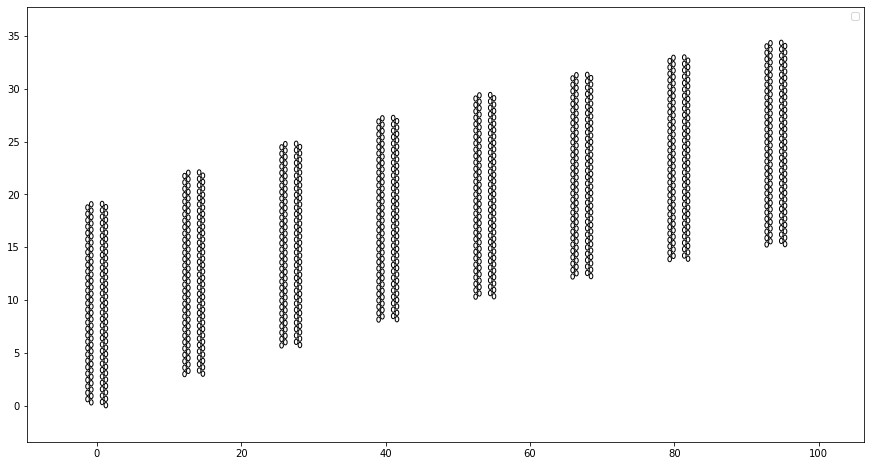

In [6]:
display_event(tracker)

## Read in the synthetic events

In [7]:
import pickle

events_file=open('synthetic_events_2110.pkl','rb')
evts_hits,evts_ids = pickle.load(events_file,encoding='latin1')

In [10]:
evts_hits.shape

(18169, 32, 32)

In [8]:
np.where(evts_hits[-1]>0)

(array([16, 16, 17, 18, 18, 19, 20, 20, 21, 21, 22, 23, 24, 24, 25, 25, 26,
        26, 28, 28, 29, 31, 31]),
 array([30, 31, 30, 29, 30, 30, 25, 26, 24, 26, 24, 25, 19, 21, 18, 21, 18,
        19, 12, 16, 15, 12, 14]))

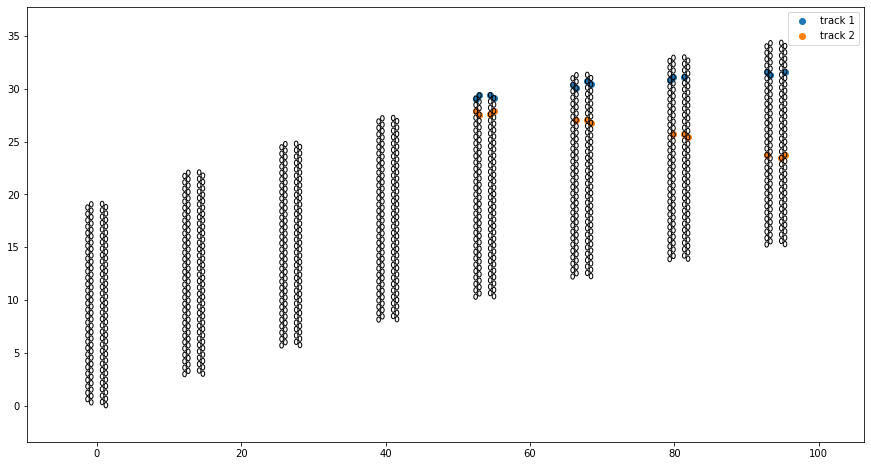

In [9]:
i_evt=50
display_event(tracker,evts_hits[i_evt],evts_ids[i_evt])

## Generate seeds

### Without truth information

Get all pure-appearing seeds within a time window, without using truth information.  
To be used for processing events to be predicted.

In [11]:
def remove_nearby(hit_straws, unique_within=3):
    '''
    Remove all hits in list that are closer together than allowed
    unique_within=4 #in each layer the hit must be unique within +-4 straws
    '''
    hit_straws=np.array(hit_straws)
    for straw in hit_straws:
        other_straws=[i for i in hit_straws if i!=straw]
        if (abs(other_straws-straw)<=unique_within).any():
            ## found hits nearby, remove them
            hit_straws=hit_straws[np.where( abs(hit_straws-straw)>unique_within)]
    return hit_straws

In [12]:
def get_next_layer_candidates(layer_hits, previous_layer_hit, max_diff=2):
    '''
    Get all candidate hits (should be 1 at most, as this should be applied after nearby hits are removed)
    that could physically belong to the same track as the hit in the previous layer,
    by checking that they are within the allowed max-diff.
    Returned list should have a length of 0 or 1.
    '''
    layer_hits=[hit for hit in layer_hits if abs(hit-previous_layer_hit)<=max_diff]
    return layer_hits
    

In [13]:
def accept_seed_candidate(candidate_hits,rms_cutoff=1):
    '''
    Accept or reject a seed candidate based on its RMS
    *** For now this is not implemented, the max-diff requirement should be enough ***
    '''
    if np.std(candidate_hits)<rms_cutoff: return True
    else: return False

In [14]:
def get_first_layer_seeds(ix,iy,first_layer):
    """
    Get all seeds that have a hit in the first layer of a module.
    Parameters:
        ix,iy: x,y coordinates of all hits in the module
        first layer: id of 1st layer in module
    Returns:
        x,y coordinates for all hits in a seed, OR empty if no seeds found.
        the ix,iy but will all hits that have been entered in seeds removed.
    """
    
    seeds_xy=[]
    candidate_straw_0,candidate_straw_1,candidate_straw_2,candidate_straw_3=0,0,0,0

    candidate_straws_0 = iy[ np.where(ix==first_layer) ]
    candidate_straws_0=remove_nearby(candidate_straws_0)
    if len(candidate_straws_0)==0: return seeds_xy, (ix,iy)

    for candidate_straw_0 in candidate_straws_0:
        ## we have a hit from 1st layer, go on to 2nd layer
        candidate_straws_1 = iy[ np.where(ix==first_layer+1) ]
        candidate_straws_1 = remove_nearby(candidate_straws_1)
        candidate_straws_1 = get_next_layer_candidates(candidate_straws_1,candidate_straw_0)
        if len(candidate_straws_1)==0: 
            ## layer-1 missed, go on to layer-2
            candidate_straws_2 = iy[ np.where(ix==first_layer+2) ]
            candidate_straws_2 = remove_nearby(candidate_straws_2)
            candidate_straws_2 = get_next_layer_candidates(candidate_straws_2,candidate_straw_0)
            if len(candidate_straws_2)==0: 
                ## second layer without hit, drop candidate
                continue
            candidate_straw_2 = candidate_straws_2[0]
            ## hits in layers 0,2, move to layer 3
            candidate_straws_3 = iy[ np.where(ix==first_layer+3) ]
            candidate_straws_3 = remove_nearby(candidate_straws_3)
            candidate_straws_3 = get_next_layer_candidates(candidate_straws_3,candidate_straw_2)            
            if len(candidate_straws_3)==0: 
                ## second layer without hit, drop candidate
                continue
            candidate_straw_3 = candidate_straws_3[0]
            
            #if not accept_seed_candidate(candidate_y): continue
            ## accept seed candidate
            candidate_x=[first_layer, first_layer+2, first_layer+3]
            candidate_y=[candidate_straw_0, candidate_straw_2, candidate_straw_3]
            seed_xy = (candidate_x,candidate_y)
            seeds_xy+=[seed_xy]

        #if len(candidate_straws_1)==0:
        else:
            ## continue with layers 0,1 hit
            candidate_straw_1 = candidate_straws_1[0]
            ## go on to layer-2
            candidate_straws_2 = iy[ np.where(ix==first_layer+2) ]
            candidate_straws_2 = remove_nearby(candidate_straws_2)
            candidate_straws_2 = get_next_layer_candidates(candidate_straws_2,candidate_straw_0)
            if len(candidate_straws_2)==0: 
                ## layer-2 missed, go on to layer-3
                candidate_straws_3 = iy[ np.where(ix==first_layer+3) ]
                candidate_straws_3 = remove_nearby(candidate_straws_3)
                candidate_straws_3 = get_next_layer_candidates(candidate_straws_3,candidate_straw_1)            
                if len(candidate_straws_3)==0: 
                    ## second layer without hit, drop candidate
                    continue
                candidate_straw_3 = candidate_straws_3[0]

                #if not accept_seed_candidate(candidate_y): continue
                ## accept seed candidate
                candidate_x=[first_layer, first_layer+1, first_layer+3]
                candidate_y=[candidate_straw_0, candidate_straw_1, candidate_straw_3]
                seed_xy = (candidate_x,candidate_y)
                seeds_xy+=[seed_xy]

            #if len(candidate_straws_2)==0: 
            else:
                ## continue with layers 0,1,2 hit            
                candidate_straw_2 = candidate_straws_2[0]
                ## go on to layer-3
                candidate_straws_3 = iy[ np.where(ix==first_layer+3) ]
                candidate_straws_3 = remove_nearby(candidate_straws_3)
                candidate_straws_3 = get_next_layer_candidates(candidate_straws_3,candidate_straw_2)            
                if len(candidate_straws_3)==0:
                    ## we missed the last layer, but we are accepting the seed anyway from the previous 3 layers
                    #if not accept_seed_candidate(candidate_y): continue
                    ## accept seed candidate
                    candidate_x=[first_layer, first_layer+1, first_layer+2]
                    candidate_y=[candidate_straw_0, candidate_straw_1, candidate_straw_2] 
                    seed_xy = (candidate_x,candidate_y)
                    seeds_xy+=[seed_xy]
                else:
                    candidate_straw_3 = candidate_straws_3[0]
                    #if not accept_seed_candidate(candidate_y): continue
                    ## accept seed candidate
                    candidate_x=[first_layer, first_layer+1, first_layer+2, first_layer+3]
                    candidate_y=[candidate_straw_0, candidate_straw_1, candidate_straw_2, candidate_straw_3] 
                    seed_xy = (candidate_x,candidate_y)
                    seeds_xy+=[seed_xy]

    ## finished processing module, return found seeds
    ## also return hit coordinates, after removing hits in seeds (so they can be entered in the 2nd-layer seed finder)
    for seed_xy in seeds_xy:
        seed_x,seed_y=seed_xy
        for iseed,iseed_x in enumerate(seed_x):
            iseed_y=seed_y[iseed]
            for ihit,ihit_x in enumerate(ix):
                ihit_y=iy[ihit]
                if (ihit_x==iseed_x) & (ihit_y==iseed_y):
                    ix=np.delete(ix,ihit)
                    iy=np.delete(iy,ihit)
                    break
    remaining_xy=(ix,iy)
    return seeds_xy, remaining_xy



In [15]:
def get_second_layer_seeds(ix,iy,first_layer):
    """
    Get all seeds that have a hit in the second layer of a module.
    Assumes that all hits from seeds found beginning in 1st layer have been removed.
    Parameters:
        ix,iy: x,y coordinates of **remaining** hits in the module
        first layer: id of 1st layer in module
    Returns:
        x,y coordinates for all hits in a seed, OR empty if no seeds found.
    """
    
    seeds_xy=[]
    candidate_straw_1,candidate_straw_2,candidate_straw_3=0,0,0

    candidate_straws_1 = iy[ np.where(ix==first_layer+1) ]
    candidate_straws_1=remove_nearby(candidate_straws_1)
    if len(candidate_straws_1)==0: return seeds_xy

    for candidate_straw_1 in candidate_straws_1:
        ## we have a hit from 2nd layer, go on to 3rd layer
        candidate_straws_2 = iy[ np.where(ix==first_layer+2) ]
        candidate_straws_2 = remove_nearby(candidate_straws_2)
        candidate_straws_2 = get_next_layer_candidates(candidate_straws_2,candidate_straw_1)
        if len(candidate_straws_2)==0: return seeds_xy
        candidate_straw_2 = candidate_straws_2[0]
        ## go on to layer-3
        candidate_straws_3 = iy[ np.where(ix==first_layer+3) ]
        candidate_straws_3 = remove_nearby(candidate_straws_3)
        candidate_straws_3 = get_next_layer_candidates(candidate_straws_3,candidate_straw_2)
        if len(candidate_straws_3)==0: return seeds_xy
        ## layers 1,2,3 hit, accept candidate
        candidate_straw_3 = candidate_straws_3[0]
        #if not accept_seed_candidate(candidate_y): continue
        candidate_x=[first_layer+1, first_layer+2, first_layer+3]
        candidate_y=[candidate_straw_1, candidate_straw_2, candidate_straw_3] 
        seed_xy = (candidate_x,candidate_y)
        seeds_xy+=[seed_xy]

    ## finished processing module, return found seeds
    return seeds_xy




In [16]:
def make_real_seeds(evt_hits):
    """
    Get all pure-appearing seeds within a time window.
    Makes no use of truth information.
    Parameters:
        evt_hits: 2D array of seeds within a window
    Returns:
        An array with x,y coordinates of all seeds.
        A 2D array (same dimension as hits) with all seed hits.
        
    """

    ## For now assume as hard-coded (this can be easily amended by passing the detector)
    n_modules=8 ## number of modules, each with 4 layers of straws
    n_layersPerModule=4
        
    seeds_xy=[]
    evt_seeds = np.zeros_like(evt_hits)
    
    ## layer/straw for all hits in event
    hit_x,hit_y = np.where(evt_hits>0)
    
    ## iterate over all modules, find seeds that fulfill requirements
    for i_module in range(n_modules):
        first_layer = n_layersPerModule*i_module
        # get hits on this module
        mask = (hit_x>=first_layer) & (hit_x<first_layer+n_layersPerModule)
        ix,iy= hit_x[mask], hit_y[mask]
        if len(ix)<3: continue
        # get seeds that start in 1st layer of this module
        module_seeds_xy, remaining_hits = get_first_layer_seeds(ix,iy,first_layer)
        if len(module_seeds_xy)>0:
            seeds_xy+=module_seeds_xy
            for module_seed_xy in module_seeds_xy:
                seed_x,seed_y=module_seed_xy
                evt_seeds[(seed_x,seed_y)]=1
        # then get seeds starting in the 2nd layer
        remaining_x,remaining_y = remaining_hits
        module_seeds_xy = get_second_layer_seeds(remaining_x,remaining_y,first_layer)
        if len(module_seeds_xy)>0:
            seeds_xy+=module_seeds_xy
            for module_seed_xy in module_seeds_xy:
                seed_x,seed_y=module_seed_xy
                evt_seeds[(seed_x,seed_y)]=1

    return seeds_xy, evt_seeds

No handles with labels found to put in legend.


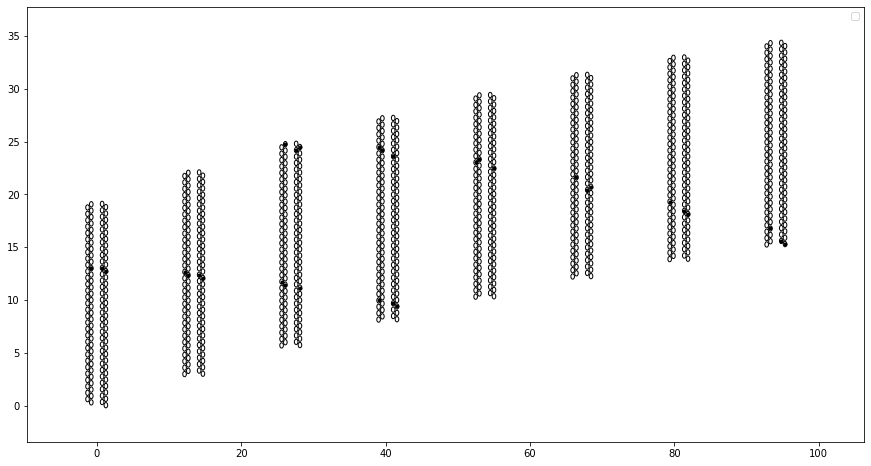

[([1, 2, 3], [21, 21, 21]), ([4, 5, 6, 7], [16, 15, 15, 15]), ([8, 9, 11], [10, 9, 9]), ([9, 10, 11], [31, 30, 31]), ([12, 14, 15], [3, 2, 2]), ([12, 13, 14], [27, 26, 25]), ([16, 17, 19], [21, 21, 20]), ([21, 22, 23], [15, 13, 14]), ([24, 26, 27], [9, 7, 7]), ([29, 30, 31], [2, 0, 0])]


No handles with labels found to put in legend.


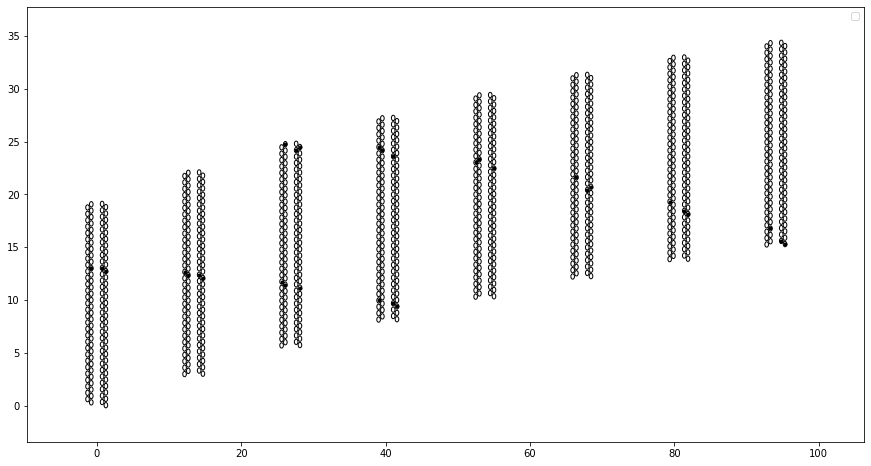

No handles with labels found to put in legend.


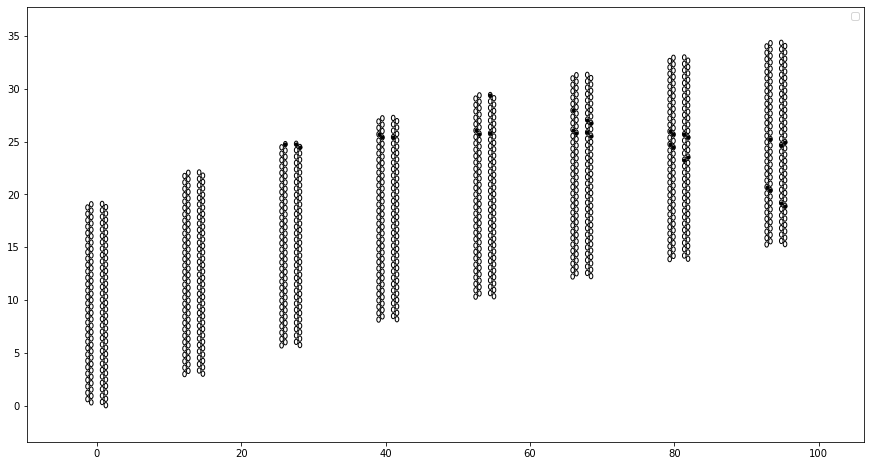

[([9, 10, 11], [31, 31, 31]), ([12, 13, 14], [29, 28, 28]), ([16, 17, 18], [26, 25, 25]), ([28, 29, 31], [9, 8, 6]), ([29, 30, 31], [16, 15, 16])]


No handles with labels found to put in legend.


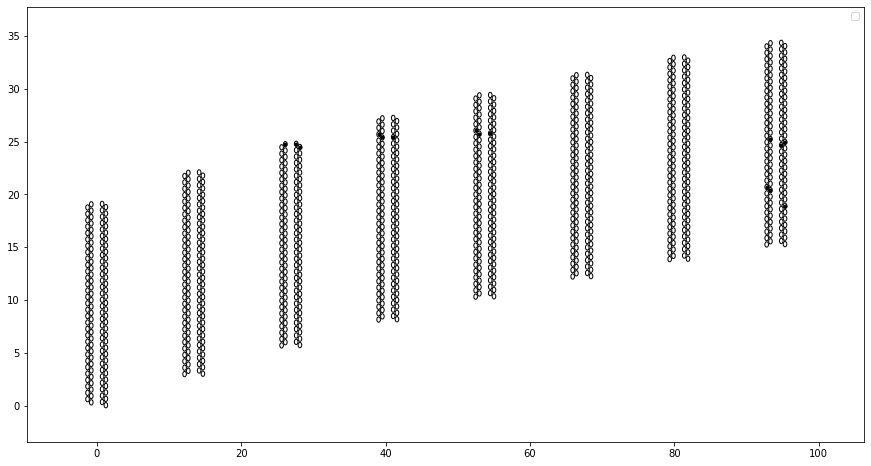

No handles with labels found to put in legend.


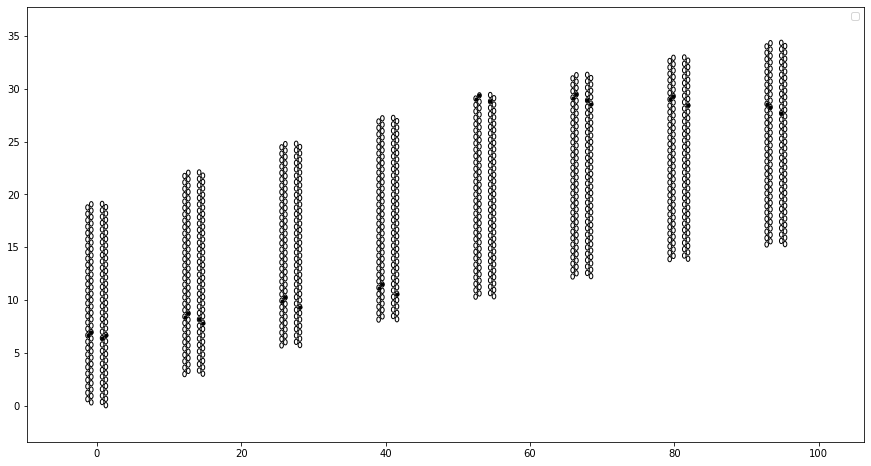

[([0, 1, 2, 3], [11, 11, 10, 11]), ([4, 5, 6, 7], [9, 9, 8, 8]), ([8, 9, 11], [7, 7, 6]), ([12, 13, 15], [5, 5, 4]), ([16, 17, 18], [31, 31, 30]), ([20, 21, 22, 23], [28, 28, 27, 27]), ([24, 25, 27], [25, 25, 24]), ([28, 29, 30], [22, 21, 20])]


No handles with labels found to put in legend.


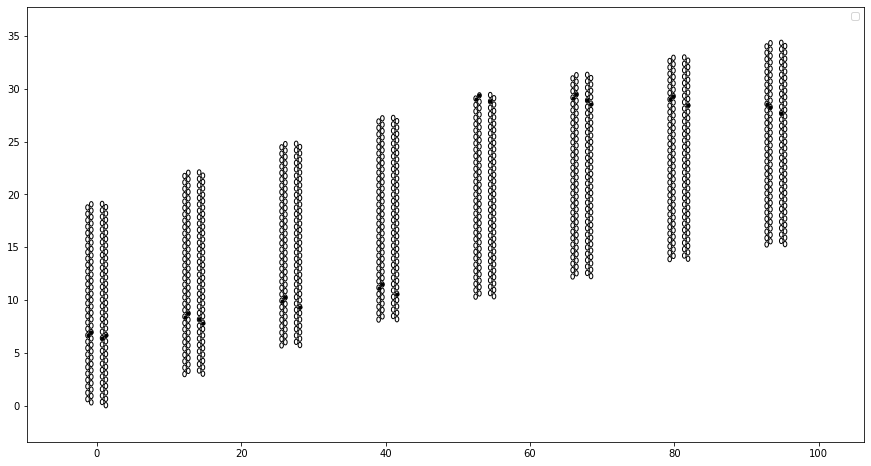

No handles with labels found to put in legend.


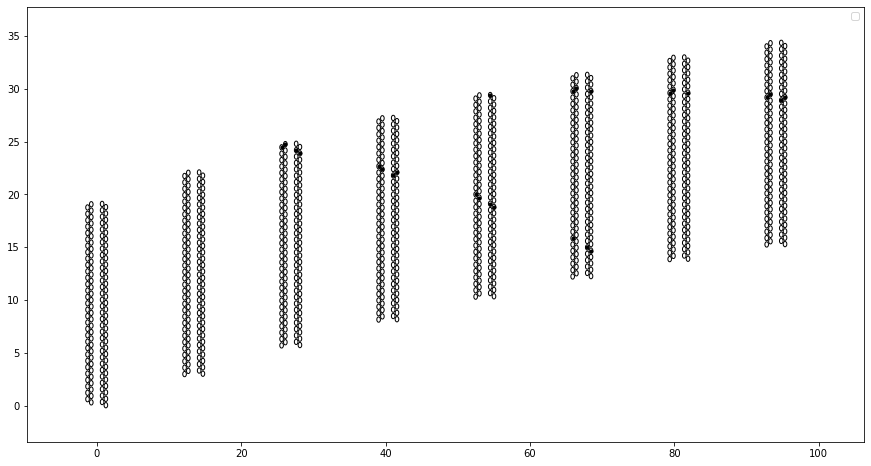

[([8, 9, 10, 11], [31, 31, 30, 30]), ([12, 13, 14, 15], [24, 23, 22, 23]), ([16, 17, 18, 19], [16, 15, 14, 14]), ([20, 22, 23], [6, 4, 4]), ([20, 21, 23], [29, 29, 29]), ([24, 25, 27], [26, 26, 26]), ([28, 29, 30, 31], [23, 23, 22, 23])]


No handles with labels found to put in legend.


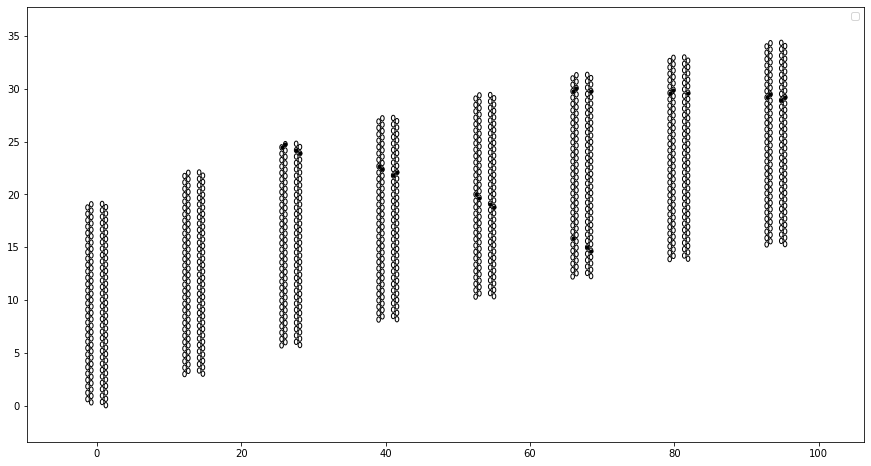

No handles with labels found to put in legend.


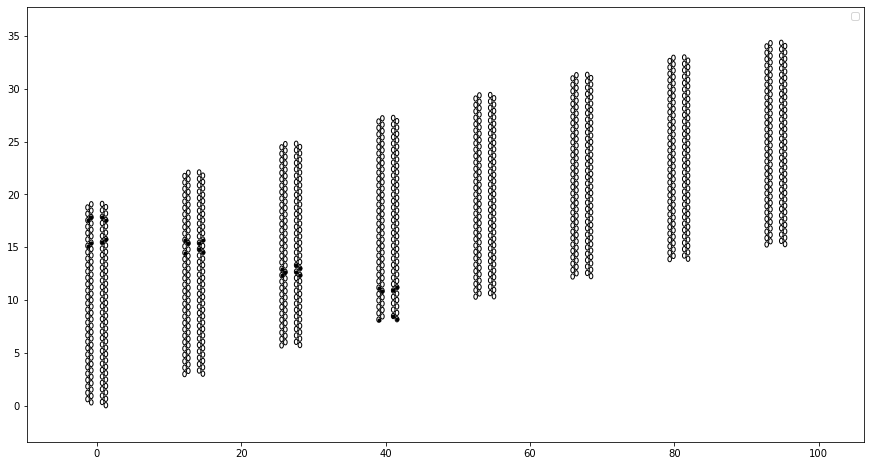

[([0, 1, 2], [25, 25, 25]), ([0, 1, 2], [29, 29, 29]), ([12, 14, 15], [0, 0, 0]), ([12, 13, 14, 15], [5, 4, 4, 5])]


No handles with labels found to put in legend.


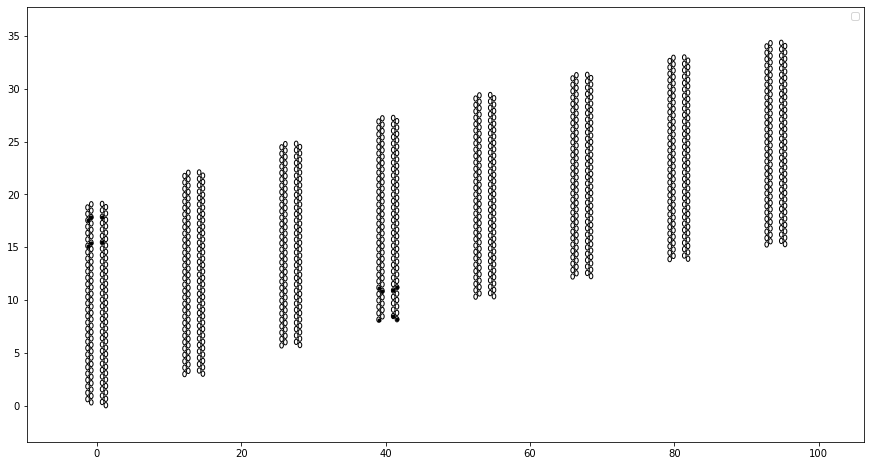

In [17]:
for i_evt in range(5,10):
    display_event(tracker, evts_hits[i_evt])
    seeds_xy,seeds = make_real_seeds(evts_hits[i_evt])
    print(seeds_xy)
    display_event(tracker, seeds)

In [18]:
x,y=seeds_xy[0]
evts_ids[i_evt][x[0]][y[0]]

2.0

## NN model

In [19]:
import keras
import pandas as pd

In [20]:
from sklearn.base import BaseEstimator
from statistics import mode


class Clusterer(BaseEstimator):
    def __init__(self, 
                 hidden_dim=50, batch_size=128, n_epochs=5, 
                 val_frac=0.1, detector=tracker):
        """
        LSTM model example.
        TODO: fill in more details.
        """
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.val_frac = val_frac
        self.detector=detector
        
        if False: '''
        self.model=None
        self.train_input = None
        self.train_target = None
        self.prepared = False     
        
        Instead, prepare 3 models, one for each region of the detector where a seed is located
        -- front, middle, back.
        '''
        
        self.model={}
        self.train_input = {}
        self.train_target = {}
        self.prepared = {}    
        self.history = {}    
        
        

    def build_model(self, 
                    model_structure='LSTMx2_Dropout',
                    loss='binary_crossentropy',## the HEPTrkX code was using categorical_ce
                    optimizer='Nadam', metrics=['accuracy']):
        n_hidden=self.hidden_dim
        length=self.detector.n_layers
        width=self.detector.n_straws 
        ## flatten the hits/seeds for each straw into a single dimension of 2*width elements
        inputs = keras.layers.Input(shape=(length, 2*width))
        hidden_1, dropout_1, hidden_2, outputs = {},{},{},{}
        for seed_location in ['front','middle','back']:

            ##bi-directional LSTM layer:
            hidden_1[seed_location] = keras.layers.Bidirectional(keras.layers.LSTM(n_hidden, return_sequences=True))(inputs)
            ## could try adding more LSTM layers, with dropout inbetween to prevent overfitting
            if ('LSTMx2' in model_structure) and ('Dropoutx2' in model_structure):
                dropout_1[seed_location] = keras.layers.Dropout(0.2)(hidden_1[seed_location])
                hidden_2[seed_location] = keras.layers.Bidirectional(keras.layers.LSTM(n_hidden, return_sequences=True))(dropout_1[seed_location])
                ## for some very weird reason, adding the 2nd dropout layer crashes on my machine...
                dropout_2[seed_location] = keras.layers.Dropout(0.2)(hidden_2)
                outputs[seed_location] = keras.layers.TimeDistributed( keras.layers.Dense(width, activation='softmax'))(dropout_2[seed_location])
            elif ('LSTMx2' in model_structure) and ('Dropout' in model_structure):
                dropout_1[seed_location] = keras.layers.Dropout(0.2)(hidden_1[seed_location])
                hidden_2[seed_location] = keras.layers.Bidirectional(keras.layers.LSTM(n_hidden, return_sequences=True))(dropout_1[seed_location])
                #dropout_2[seed_location] = keras.layers.Dropout(0.2)(hidden_2)
                outputs[seed_location] = keras.layers.TimeDistributed( keras.layers.Dense(width, activation='softmax'))(hidden_2[seed_location])
            elif ('LSTMx2' in model_structure) and ('Dropout' not in model_structure):
                hidden_2[seed_location] = keras.layers.Bidirectional(keras.layers.LSTM(n_hidden, return_sequences=True))(hidden_1[seed_location])
                outputs[seed_location] = keras.layers.TimeDistributed( keras.layers.Dense(width, activation='softmax'))(hidden_2[seed_location])
            else:
                outputs[seed_location] = hidden_1[seed_location]

            self.model[seed_location] = keras.Model(inputs, outputs[seed_location])
            self.model[seed_location].compile(loss=loss, optimizer=optimizer, metrics=metrics)            
          
    '''
    Can we make loss function give bigger weight to events with many hits?
    That would train the model to deal with complexity.
    
    Also consider "momentum acceleration" or other modifications of learning rate for better convergence.
    '''

        
    def prepare_training_data(self, evts_hits, evts_ids):
        """
        Prepare training data. 
        Reads in 3D arrays of hits and ids in many event windows.
        The 1st dimension is the event number.
        The hits and ids within each window  are of the same shape: (length,width).
        Within each window generate seeds.
        *** In this iteration, seeds are genrated anywhere in the tracker, and multiple per track ***
        Training input and target are prepared in the same way as the HEPTrkX example.
        The input will be of shape (n_seeds, length, width)
        """
        #if self.prepared: return
        #self.prepared = True
        
        n_events = evts_hits.shape[0]
        max_seeds = n_events * self.detector.max_tracks * self.detector.n_modules / 2 # divide by 2 since seeds are split in ~3
        print_freq = int(max_seeds / 20)

        holder_input, holder_target={},{}
        n_seeds={} # this will be a counter for seeds we find
        for seed_location in ['front','middle','back']:
            holder_input[seed_location] = np.zeros((int(max_seeds), 
                                                    self.detector.n_layers, 
                                                    2*self.detector.n_straws))
            holder_target[seed_location] = np.zeros((int(max_seeds), 
                                                     self.detector.n_layers, 
                                                     self.detector.n_straws))
            n_seeds[seed_location]=0
    
        ## Iterate over all windows (events)
        for i_evt in range(n_events):

            ## All hits coordinates in this event
            allhits_layers,allhits_straws=np.where(evts_hits[i_evt]>0)

            ## Get all seeds in this event
            seeds_xy, seeds_array=make_real_seeds(evts_ids[i_evt])
            if len(seeds_xy)==0: continue  
            
            ## Step through each module
            for i_module in range(self.detector.n_modules):

                if i_module<=2: seed_location='front'
                elif i_module<=5: seed_location='middle'
                else: seed_location='back' 
                
                ## Get seeds in this module
                module_seeds_xy = [seed_xy for seed_xy in seeds_xy if (
                    (seed_xy[0][0]>=i_module*4) & (seed_xy[0][0]<i_module*4+4) )]
                if len(module_seeds_xy)==0: continue

                for seed_xy in module_seeds_xy:
                    ## format input for this seed     
                                    
                    ## first turn on the seed hits after finding their (layer,straw) location
                    seed_layers,seed_straws = seed_xy
                    for i,ilayer in enumerate(seed_layers):
                        istraw=seed_straws[i]
                        ## turn on both hits and seeds elements
                        holder_input[seed_location][n_seeds[seed_location]][ilayer][istraw] = 1   
                        holder_input[seed_location][n_seeds[seed_location]][ilayer][self.detector.n_straws+istraw] = 1   

                    ## now turn on all the hits from different modules in the event
                    not_module_mask = (allhits_layers<4*i_module) | (allhits_layers>=4*i_module+4)
                    ilayers,istraws=allhits_layers[not_module_mask], allhits_straws[not_module_mask] # this excludes hits from the same module as the seed 
                    for i,ilayer in enumerate(ilayers):
                        istraw=istraws[i]
                        holder_input[seed_location][n_seeds[seed_location]][ilayer][istraw] = 1

                    ## now set the target as an image of all hits from the same track as the seed
                    ## get track id for the seed hits
                    seed_ids = evts_ids[i_evt][seed_layers,seed_straws]
                    if (seed_ids==seed_ids[0]).sum() == len(seed_ids):
                        # all hits in seed belong to same track
                        seed_id = seed_ids[0]
                    else: 
                        # oops, at least some hits are false.
                        # could get the track most encountered with eg: mode(seed_ids)
                        # but best to skip this seed from training for now, after we turn off all hits again
                        holder_input[seed_location][n_seeds[seed_location]] = np.zeros(
                            (self.detector.n_layers, 
                             2*self.detector.n_straws) )
                        continue
                    ilayers,istraws=np.where((evts_ids[i_evt]==seed_id))
                    for i,ilayer in enumerate(ilayers):
                        istraw=istraws[i]
                        holder_target[seed_location][n_seeds[seed_location]][ilayer][istraw] = 1

                    ## finished processing this seed, increment
                    n_seeds[seed_location] += 1
                    if (n_seeds[seed_location] % print_freq == 0):
                        print (' Processing seed #%d in %s seed-location' % (n_seeds[seed_location], seed_location) )

        print ('\nTotal seeds processed per location: ', n_seeds)
              
        ## Now remove all the extra array dimensions, keep only n_seeds
        for seed_location in ['front','middle','back']:
            self.train_input[seed_location] = holder_input[seed_location][:n_seeds[seed_location],:,:]
            self.train_target[seed_location] = holder_target[seed_location][:n_seeds[seed_location],:,:]
        

            
    def fit(self, evts_hits, evts_ids):
        #self.prepare_training_data_NoDF(evts_hits, evts_ids)
        self.prepare_training_data(evts_hits, evts_ids)
        print('Starting training...')
        for seed_location in ['front','middle','back']:
            self.history[seed_location] = self.model[seed_location].fit(
                self.train_input[seed_location], self.train_target[seed_location],
                batch_size=self.batch_size, epochs=self.n_epochs,
                validation_split=self.val_frac)

      
    def prepare_event_for_prediction(self, evt_hits):
        """
        After the model has been trained, we will want to predict individual events.
        This function processes the 2D arrays of individual events in the proper format for model.predict().
        Reads in the 2D array of hits in the event, of shape: (length,width).
        Generate real seeds from the event hits.
        *** In this iteration, seeds are genrated anywhere in the tracker, and multiple per track ***
        The input for prediction will be of shape (n_seeds, length, width)
        """
        
        ## All hits coordinates in this event
        allhits_layers,allhits_straws=np.where(evt_hits>0)

        ## First form seeds in the event
        seeds_xy, seeds_array=make_real_seeds(evt_hits)

        ## count seeds
        n_seeds={} 
        for seed_location in ['front','middle','back']:
            n_seeds[seed_location]=0
        module_seeds_xy={}
        ## Step through each module to count seeds
        for i_module in range(self.detector.n_modules):
            if i_module<=2: seed_location='front'
            elif i_module<=5: seed_location='middle'
            else: seed_location='back'
                
            module_seeds_xy[i_module] = [seed_xy for seed_xy in seeds_xy if (
                (seed_xy[0][0]>=i_module*4) & (seed_xy[0][0]<i_module*4+4) )]
            n_seeds[seed_location] += len(module_seeds_xy[i_module])
        
        model_input,i_seed={},{}
        ## Input format
        for seed_location in ['front','middle','back']:
            model_input[seed_location] = np.zeros((n_seeds[seed_location], 
                                                   self.detector.n_layers,  
                                                   2*self.detector.n_straws))
            i_seed[seed_location]=0 ## counter for seeds; must equal n_seeds eventually
        ## Step through each module to format input for each seed
        for i_module in range(self.detector.n_modules):
            if i_module<=2: seed_location='front'
            elif i_module<=5: seed_location='middle'
            else: seed_location='back'

            ## we already have seeds for each module, iterate through them
            for seed_xy in module_seeds_xy[i_module]:
                ## format input for this seed     
                                    
                ## first turn on the seed hits after finding their (layer,straw) location
                seed_layers,seed_straws = seed_xy
                for i,ilayer in enumerate(seed_layers):
                    istraw=seed_straws[i]
                    ## turn on both hits and seeds elements
                    model_input[seed_location][i_seed[seed_location]][ilayer][istraw] = 1   
                    model_input[seed_location][i_seed[seed_location]][ilayer][self.detector.n_straws+istraw] = 1   

                    ## now turn on all the hits from different modules in the event
                    not_module_mask = (allhits_layers<4*i_module) | (allhits_layers>=4*i_module+4)
                    ilayers,istraws=allhits_layers[not_module_mask], allhits_straws[not_module_mask] # this excludes hits from the same module as the seed 
                    for i,ilayer in enumerate(ilayers):
                        istraw=istraws[i]
                        model_input[seed_location][i_seed[seed_location]][ilayer][istraw] = 1

                ## finished processing this seed, increment
                i_seed[seed_location] += 1
            
        return model_input
    
    
    

# Build and train

In [21]:
tracker_NN=Clusterer(hidden_dim=120,
                     batch_size=100, 
                     n_epochs=12, val_frac=0.1, detector=tracker)


In [22]:
def draw_train_history(history, draw_val=True, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    for seed_location in ['front','middle','back']:
        plt.figure(figsize=figsize)
        # Plot loss
        plt.subplot(121)
        plt.plot(history[seed_location].epoch, history[seed_location].history['loss'], label='Training set')
        if draw_val:
            plt.plot(history[seed_location].epoch, history[seed_location].history['val_loss'], label='Validation set')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(history[seed_location].epoch, history[seed_location].history['accuracy'], label='Training set')
        if draw_val:
            plt.plot(history[seed_location].epoch, history[seed_location].history['val_accuracy'], label='Validation set')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim((0, 1))
        plt.title('Training accuracy')
        plt.legend(loc=0)
        plt.tight_layout()




In [31]:
from sklearn.model_selection import train_test_split
evts_hits_train, evts_hits_valid, evts_ids_train, evts_ids_valid = train_test_split(evts_hits,evts_ids, train_size=0.8)

In [32]:
evts_ids_valid.shape

(3634, 32, 32)

In [260]:
## build model and train
tracker_NN.build_model(model_structure='LSTMx2_Dropout')
for seed_location in ['front','middle','back']:
    tracker_NN.model[seed_location].summary()

tracker_NN.fit(evts_hits_train, evts_ids_train)
draw_train_history(tracker_NN.history)

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 64)]          0         
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 32, 240)           177600    
_________________________________________________________________
dropout_24 (Dropout)         (None, 32, 240)           0         
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 32, 240)           346560    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 32, 32)            7712      
Total params: 531,872
Trainable params: 531,872
Non-trainable params: 0
_________________________________________________________________
Model: "model_25"
_________________________________________________________________
Layer (type)                 Outpu

KeyboardInterrupt: 

 Processing seed #8721 in middle seed-location
 Processing seed #8721 in front seed-location
 Processing seed #8721 in back seed-location
 Processing seed #17442 in middle seed-location
 Processing seed #26163 in middle seed-location
 Processing seed #17442 in front seed-location
 Processing seed #17442 in back seed-location
 Processing seed #34884 in middle seed-location
 Processing seed #43605 in middle seed-location
 Processing seed #26163 in front seed-location

Total seeds processed per location:  {'front': 27164, 'middle': 46982, 'back': 23754}
Starting training...
Epoch 1/15
245/245 [==============================] - 43s 177ms/step - loss: 0.0143 - accuracy: 0.5793 - val_loss: 0.0156 - val_accuracy: 0.5695
Epoch 2/15
245/245 [==============================] - 46s 187ms/step - loss: 0.0143 - accuracy: 0.5808 - val_loss: 0.0156 - val_accuracy: 0.5668
Epoch 3/15
245/245 [==============================] - 45s 183ms/step - loss: 0.0143 - accuracy: 0.5806 - val_loss: 0.0156 - val_accu

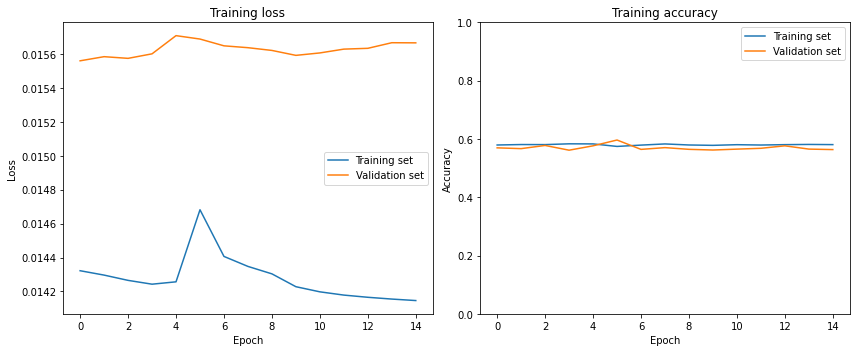

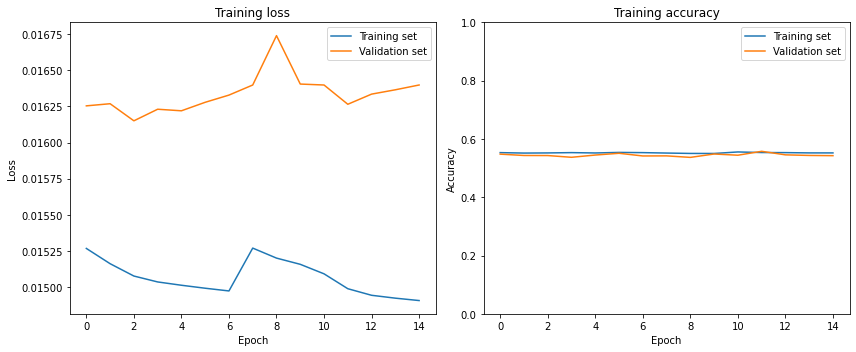

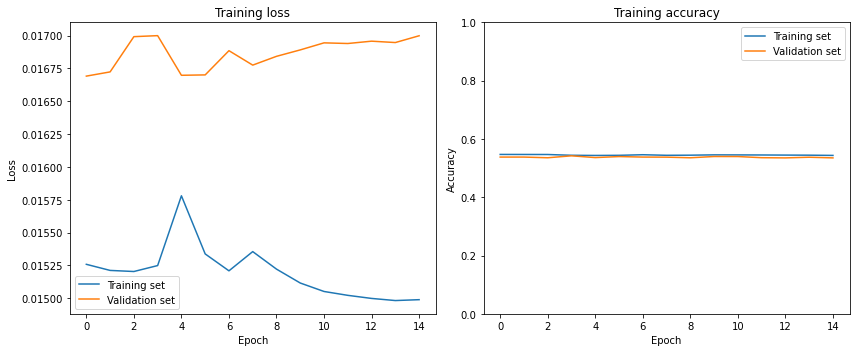

In [34]:
## 9/29 retraining on synthetic data with real seeds
tracker_NN.n_epochs=15
tracker_NN.fit(evts_hits_train, evts_ids_train)
draw_train_history(tracker_NN.history)

In [280]:
'''
# 8/11 Repeating fit with more events (same number, new set)
tracker_NN.fit(evts_hits, evts_ids)
draw_train_history(tracker_NN.history)
'''

'\n# 8/11 Repeating fit with more events (same number, new set)\ntracker_NN.fit(evts_hits, evts_ids)\ndraw_train_history(tracker_NN.history)\n'

In [23]:
## To load an existing model, use:
tracker_NN.build_model(model_structure='LSTMx2_Dropout')
for seed_location in ['front','middle','back']:
    tracker_NN.model[seed_location] = keras.models.load_model('tracker_NN_%s_2109_FirstSynthetic.h5'%seed_location)
    tracker_NN.model[seed_location].summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 64)]          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 32, 240)           177600    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 32, 240)           346560    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 32, 32)            7712      
Total params: 531,872
Trainable params: 531,872
Non-trainable params: 0
_________________________________________________________________
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 64)]          0         
____________________________________

In [24]:
## save models after fitting
'''
for seed_location in ['front','middle','back']:
    tracker_NN.model[seed_location].save('tracker_NN_%s_2109_FirstSynthetic.h5'%seed_location) 
'''

## Training notes

#### Need more synthetic events to train on
Very few for good training.

#### Overfitting 
We definitely overfit on such a small dataset.
Need to put the 2nd Dropout back in -- previously was getting errors.

## Examine output


In [35]:
def plot_event_NNoutput(evt_hits, evt_ids=False, selection_threshold=0.6):
    ## make passing ids optional

    ## Get all seeds in the event
    seeds_xy, seeds_array=make_real_seeds(evt_hits)
    module_seeds_xy={}
    n_seeds={}
    for seed_location in ['front','middle','back']:
        n_seeds[seed_location]=0
    ## Step through each module to count seeds
    for i_module in range(tracker_NN.detector.n_modules):
        if i_module<=2: seed_location='front'
        elif i_module<=5: seed_location='middle'
        else: seed_location='back'
        module_seeds_xy[i_module] = [seed_xy for seed_xy in seeds_xy if (
            (seed_xy[0][0]>=i_module*4) & (seed_xy[0][0]<i_module*4+4) )]
        n_seeds[seed_location] += len(module_seeds_xy[i_module])
    n_seeds_total = n_seeds['front']+n_seeds['middle']+n_seeds['back']
    #print(' Found %d total seeds in the event' % n_seeds_total) 
        

    ## Format model input for event
    model_input = tracker_NN.prepare_event_for_prediction(evt_hits)

    ## Get model prediction
    model_prediction={}
    for seed_location in ['front','middle','back']:
        if n_seeds[seed_location]>0:
            model_prediction[seed_location] = tracker_NN.model[seed_location].predict(model_input[seed_location])
        else: model_prediction[seed_location]=None
    
    model_prediction_full = np.zeros( (n_seeds_total, tracker_NN.detector.n_layers, tracker_NN.detector.n_straws) )
    model_prediction_full[:n_seeds['front']] = model_prediction['front']
    model_prediction_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']] = model_prediction['middle']
    model_prediction_full[n_seeds['front']+n_seeds['middle']:] = model_prediction['back']
    model_prediction_selected = np.zeros_like(model_prediction_full)
    model_prediction_selected[np.where(model_prediction_full>selection_threshold)] = 1


    ### Now plot input and prediction per seed

    full_detector_width = tracker_NN.detector.width
    
    ## put all straw locations in a df
    layer_v, straw_v, x_v, y_v =[],[],[],[]
    for ilayer in range(tracker_NN.detector.n_layers):
        for istraw in range(tracker_NN.detector.n_straws):
            layer_v+= [ilayer]
            straw_v+= [istraw]
            x_v+= [tracker_NN.detector.x[ilayer] ]
            y_v+= [tracker_NN.detector.y[ilayer][istraw] ]
    df = pd.DataFrame({'layer':layer_v, 'straw':straw_v, 'x':x_v, 'y':y_v})

    ## Step through each module to plot output for each seed
    input_seed=0       
    for i_module in range(tracker_NN.detector.n_modules):
        for seed_xy in module_seeds_xy[i_module]:
            if i_module<=2: seed_location='front'
            elif i_module<=5: seed_location='middle'
            else: seed_location='back'

            ## Make vectors with the model predictions at each straw for this seed,
            ## and add to the df.
            ## This is used for the color-coded plot of the model prediction, remove if no longer necessary
            ## (though it could also be useful for event-level analysis/disambiguation)
            prediction_v, prediction_selected_v =[],[]
            for ilayer in range(tracker_NN.detector.n_layers):
                for istraw in range(tracker_NN.detector.n_straws):
                    prediction_v+= [ model_prediction_full[input_seed][ilayer][istraw] ]
                    prediction_selected_v+= [ model_prediction_selected[input_seed][ilayer][istraw] ]
            df['prediction'] = prediction_v
            df['prediction_selected'] = prediction_selected_v


            fig, axs = plt.subplots(figsize=(20,8))        
            ## First plot the model input
            axs.set_title('Seed#%d in module#%d'%(input_seed, i_module))

            axs.set_xlim((-0.1*tracker_NN.detector.length, 1.1*tracker_NN.detector.length))
            axs.set_ylim((-0.1*full_detector_width, 1.1*full_detector_width))

            # plot a circle at the location of each straw
            for ilayer,straw_x in enumerate(tracker_NN.detector.x):
                for straw_y in tracker_NN.detector.y[ilayer]:
                    circle = plt.Circle((straw_x, straw_y), tracker_NN.detector.straw_radius, color='black', fill=False)
                    axs.add_patch(circle)

            # plot the model input for this seed/event
            i_seed_location = input_seed
            if seed_location=='middle': i_seed_location -= n_seeds['front']
            elif seed_location=='back': i_seed_location -= ( n_seeds['front'] + n_seeds['middle'] )
            hits_x,hits_y=np.where(model_input[seed_location][i_seed_location][:,:tracker_NN.detector.n_straws]==1)
            axs.scatter(tracker_NN.detector.x[hits_x],tracker_NN.detector.y[hits_x,hits_y], marker='.', color='black')
            plt.show()

            ## Plot the raw NN output, which is a number that roughly translates 
            ## to the probability that each straw (even those that weren't hit)
            ## belongs to the same track as the seed
            fig, axs = plt.subplots(figsize=(20,8))        
            axs.set_title('NN raw output')

            axs.set_xlim((-0.1*tracker_NN.detector.length, 1.1*tracker_NN.detector.length))
            axs.set_ylim((-0.1*full_detector_width, 1.1*full_detector_width))
            # plot a circle at the location of each straw
            for ilayer,straw_x in enumerate(tracker_NN.detector.x):
                for straw_y in tracker_NN.detector.y[ilayer]:
                    circle = plt.Circle((straw_x, straw_y), tracker_NN.detector.straw_radius, color='black', fill=False)
                    axs.add_patch(circle)

            plt.scatter( df['x'], df['y'] , c=df['prediction'], 
                        cmap = 'RdPu', alpha =0.5) 
            plt.show()


            ## Plot the rounded NN output, before any cleanup/disambiguation
            fig, axs = plt.subplots(figsize=(20,8))       
            axs.set_title('NN selected hits')

            axs.set_xlim((-0.1*tracker_NN.detector.length, 1.1*tracker_NN.detector.length))
            axs.set_ylim((-0.1*full_detector_width, 1.1*full_detector_width))
            # plot a circle at the location of each straw
            for ilayer,straw_x in enumerate(tracker_NN.detector.x):
                for straw_y in tracker_NN.detector.y[ilayer]:
                    circle = plt.Circle((straw_x, straw_y), tracker_NN.detector.straw_radius, color='black', fill=False)
                    axs.add_patch(circle)
            hits_x,hits_y=np.where(model_prediction_selected[input_seed]==1)
            axs.scatter(tracker_NN.detector.x[hits_x],tracker_NN.detector.y[hits_x,hits_y], marker='.', color='blue')
            plt.show()
            
            
            ### Plot the NN output values corresponding to the straws that are predicted to belong to the track
            fig, axs = plt.subplots()      
            axs.set_title('NN output for straws that are predicted to belong to the track')
            hits_x,hits_y=np.where(model_prediction_selected[input_seed]==1)
            axs.hist(model_prediction_full[input_seed][hits_x,hits_y])
            plt.show()
            print ('RMS = %.4f' % np.std(model_prediction_full[input_seed][hits_x,hits_y]))

            
            ## If we haven't passed the truth, then we're done
            if evt_ids is False: return

            ### Now plot relative to the truth, if it is passed
            ## get track id for the seed hits
            seed_ids = evt_ids[seed_xy]
            if (seed_ids==seed_ids[0]).sum() != len(seed_ids):
                print('Oopss!! Seed is not 100% pure. \nWe will just use the seed-id of the first hit for now ')
            seed_id = seed_ids[0]
            

            ### Plot the NN output values corresponding to the straws that belong to the track
            fig, axs = plt.subplots()    
            axs.set_title('NN output for straws that belong to the track')
            hits_x,hits_y=np.where(evt_ids==seed_id)
            axs.hist(model_prediction_full[input_seed][hits_x,hits_y])
            plt.show()
            print ('RMS = %.4f' % np.std(model_prediction_full[input_seed][hits_x,hits_y]))


            ### Plot the NN output values corresponding to the straws that are predicted to belong to the track,
            ### but actually don't
            fig, axs = plt.subplots()        
            axs.set_title("NN output for straws that are predicted to belong to the track, but don't")
            badpred_x,badpred_y=np.where( (model_prediction_selected[input_seed]==1) & (evt_ids!=seed_id))
            axs.hist(model_prediction_full[input_seed][badpred_x,badpred_y])
            plt.show()
            print ('RMS = %.4f' % np.std(model_prediction_full[input_seed][badpred_x,badpred_y]))            
            '''badpred_x,badpred_y=[],[]
            for i,ix in enumerate(hits_x):
                iy=hits_y[i]
                if evts_ids[i_evt][ix][iy]!=i_seed:
                    badpred_x+=[ix]
                    badpred_y+=[iy]                        
            axs.hist(model_prediction_full[input_seed][badpred_x,badpred_y])
            plt.show()
            print ('RMS = %.4f' % np.std(model_prediction_full[input_seed][badpred_x,badpred_y]))
            '''

            input_seed+=1







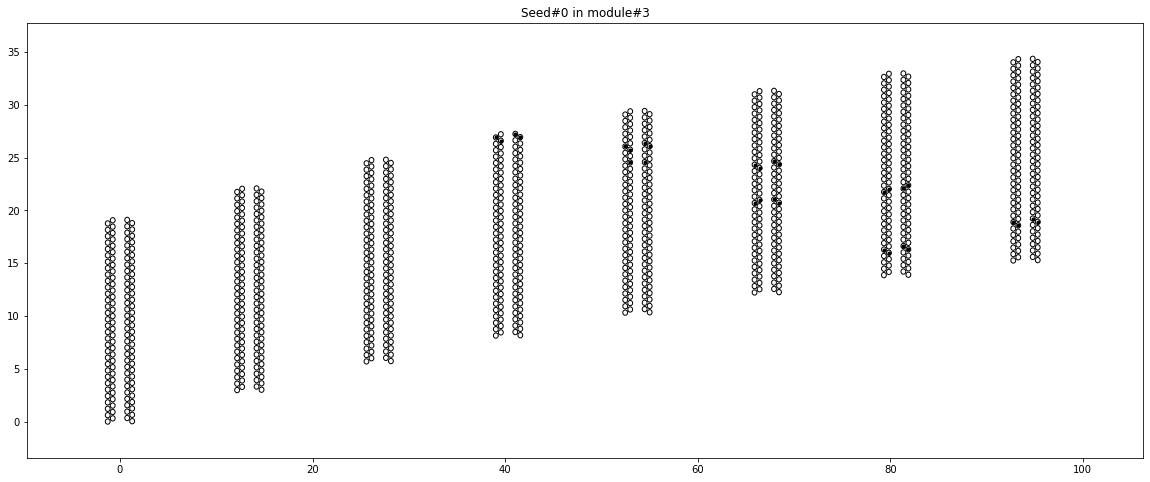

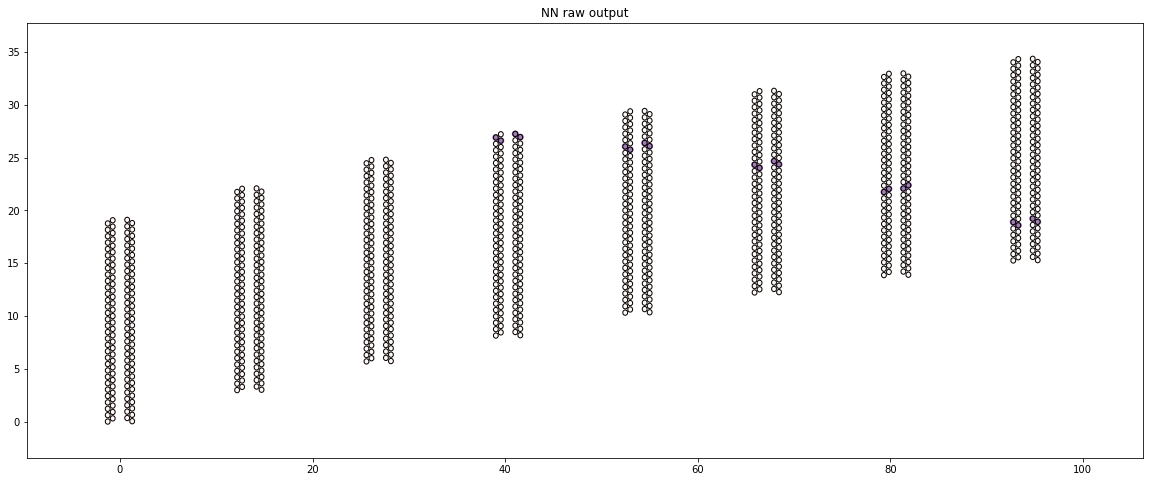

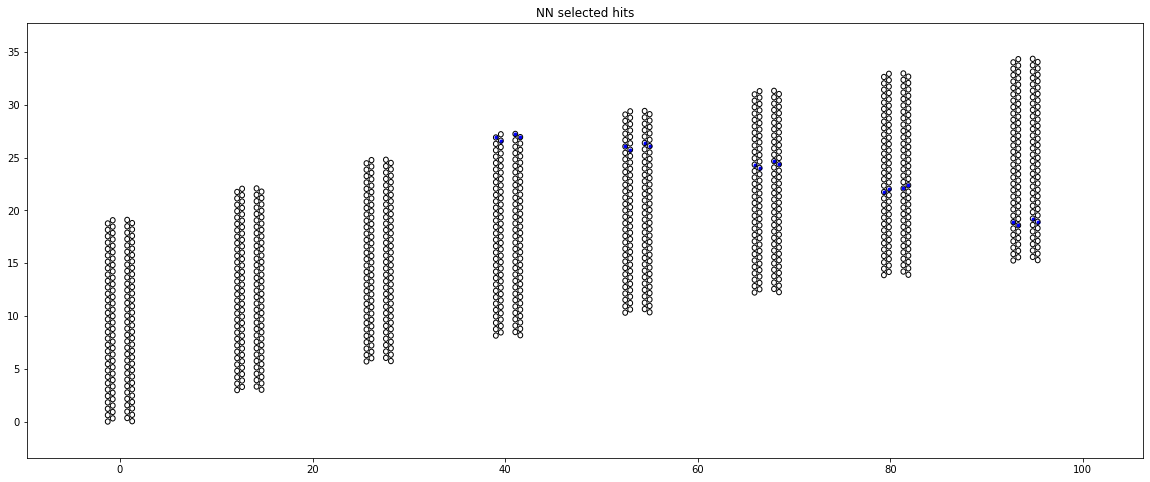

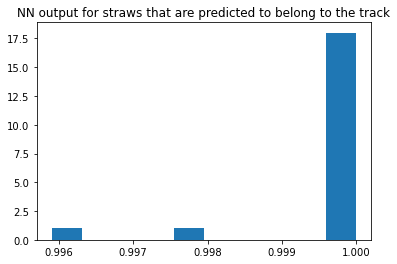

RMS = 0.0010
Oopss!! Seed is not 100% pure. 
We will just use the seed-id of the first hit for now 


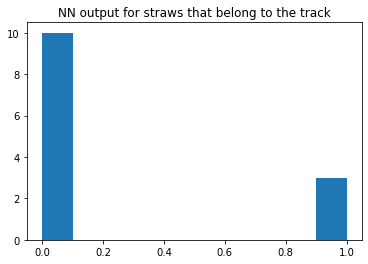

RMS = 0.4212


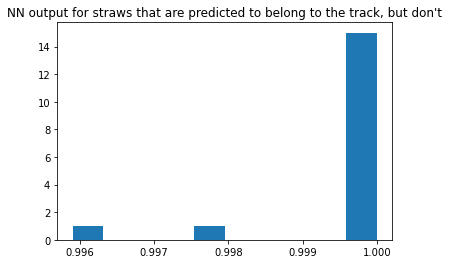

RMS = 0.0011


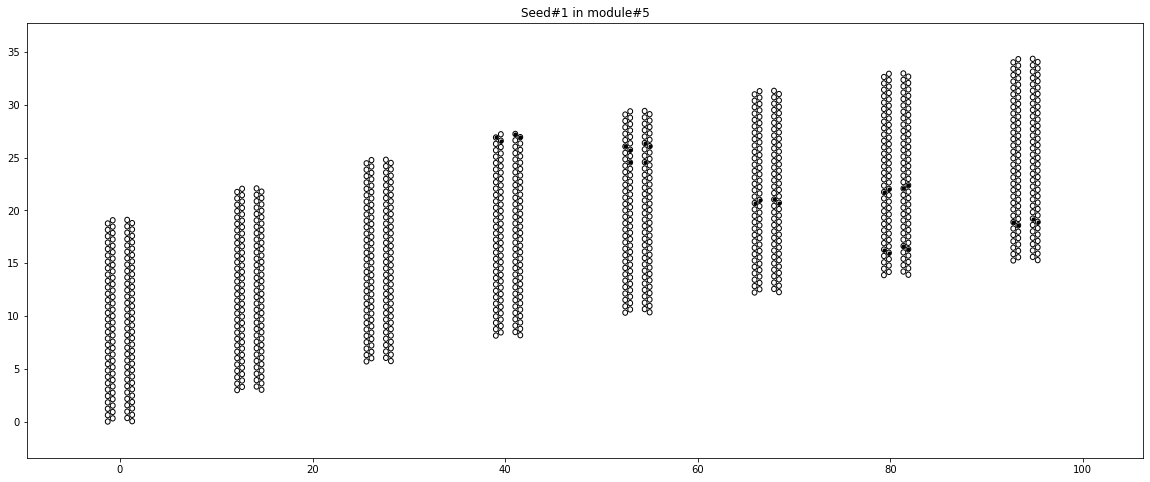

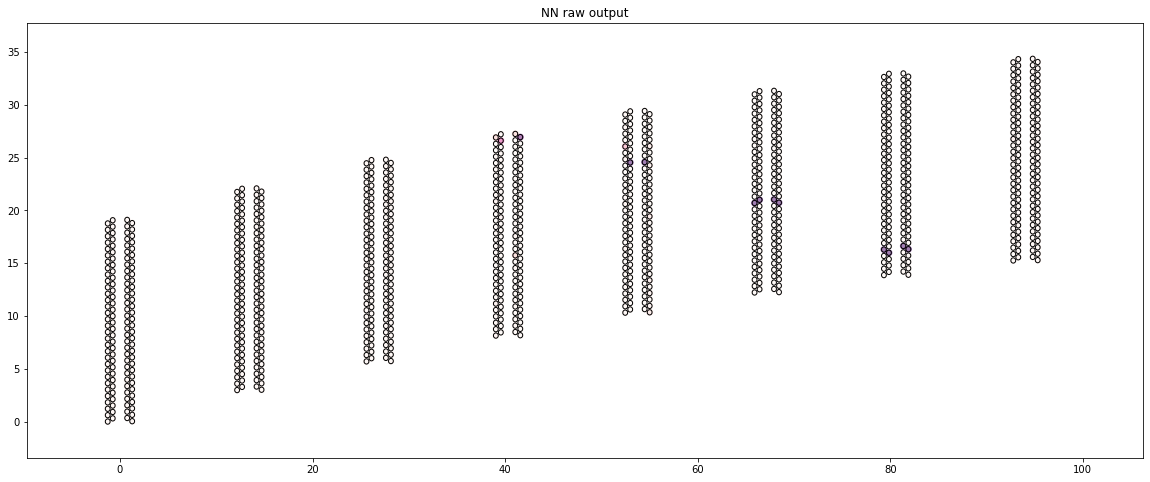

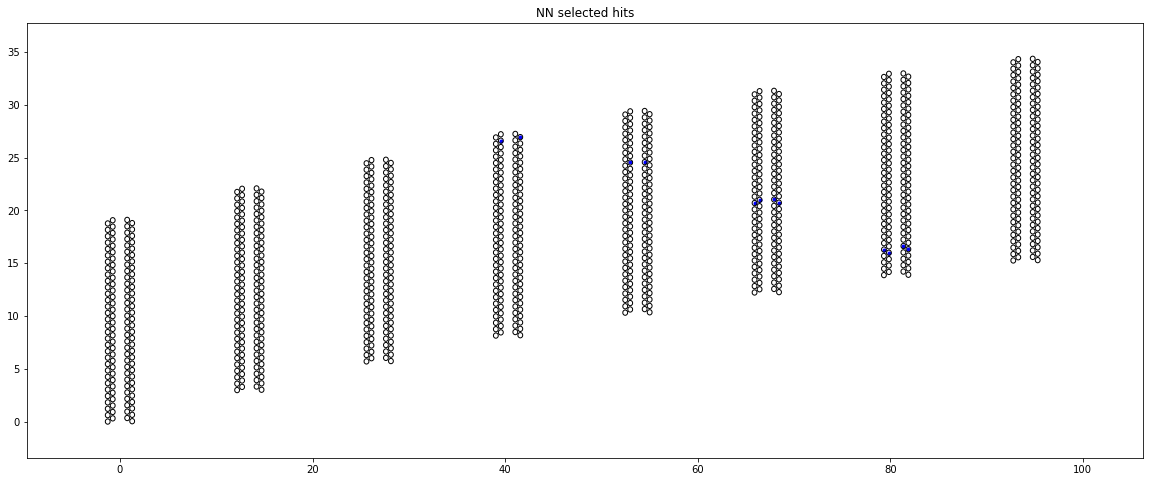

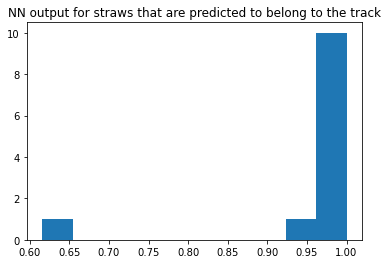

RMS = 0.1062


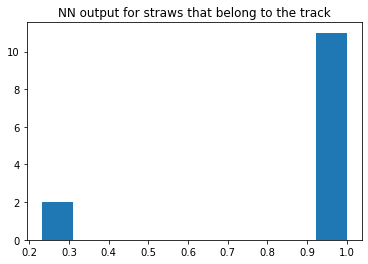

RMS = 0.2726


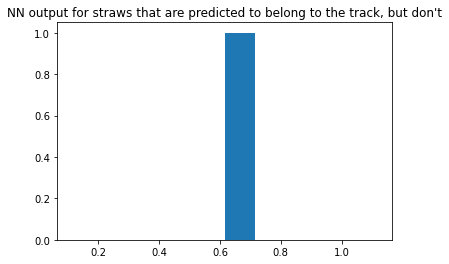

RMS = 0.0000


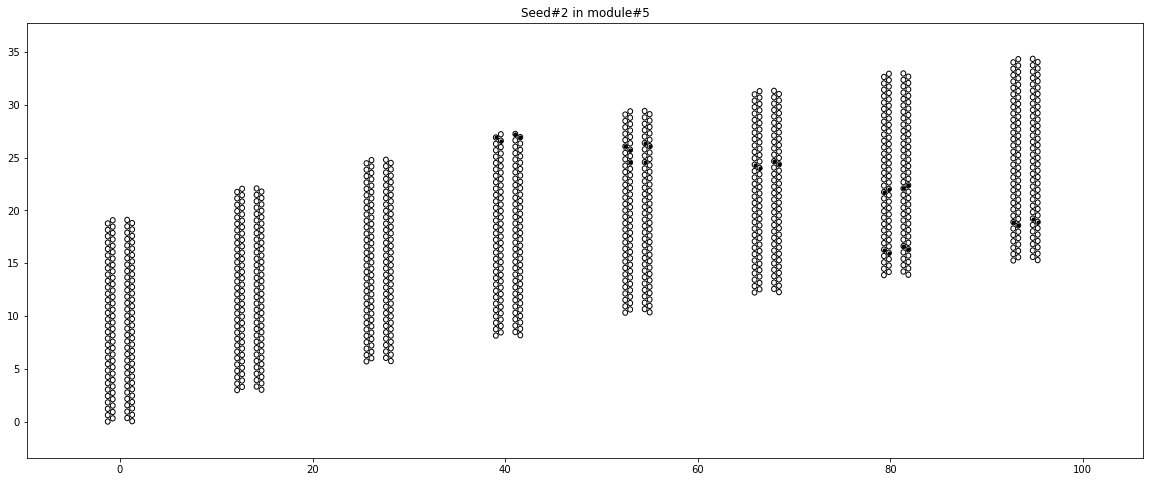

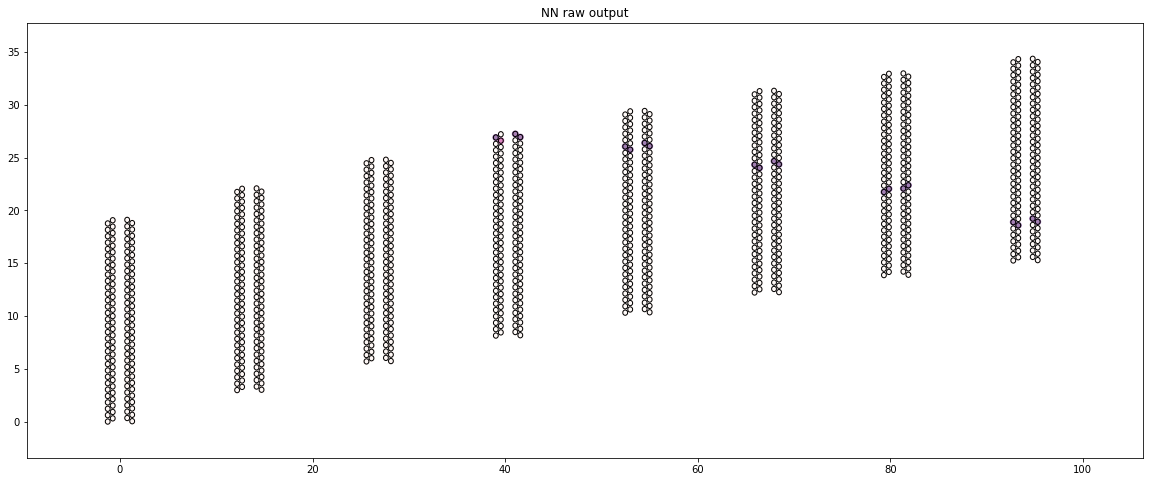

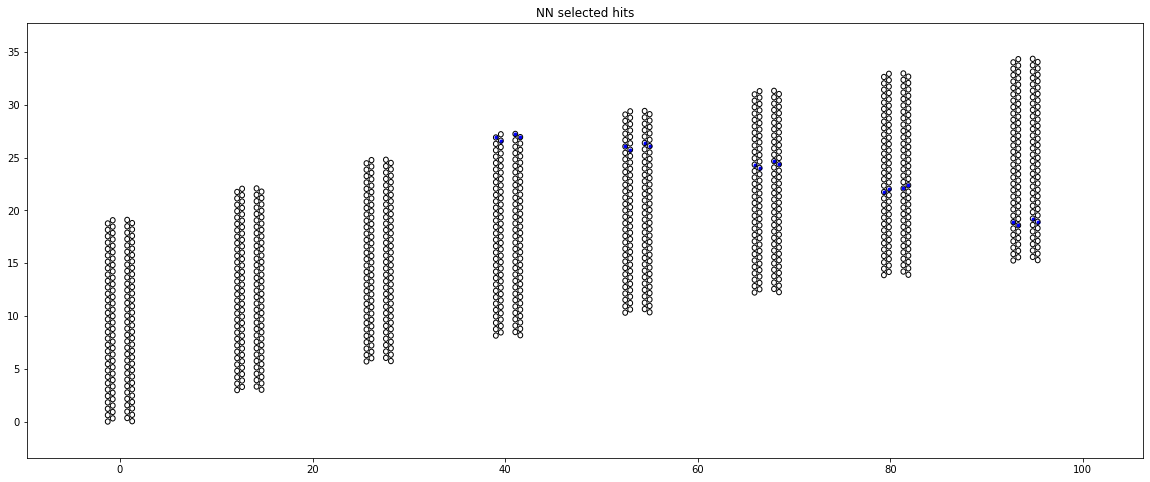

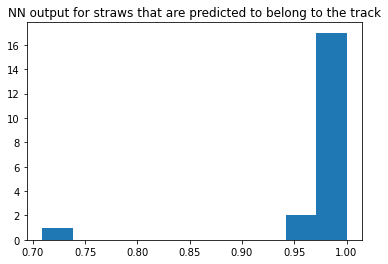

RMS = 0.0634


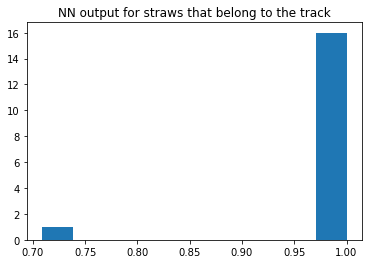

RMS = 0.0684


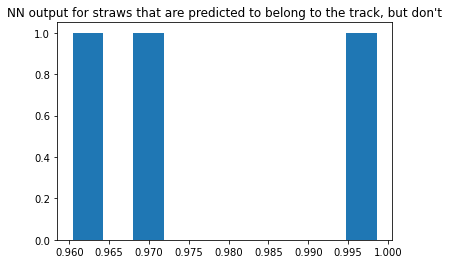

RMS = 0.0165


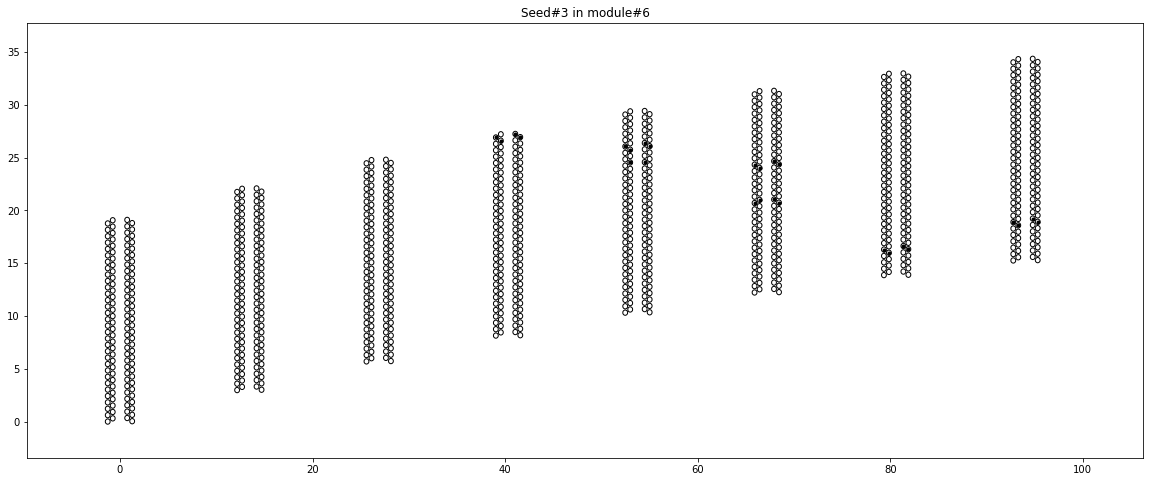

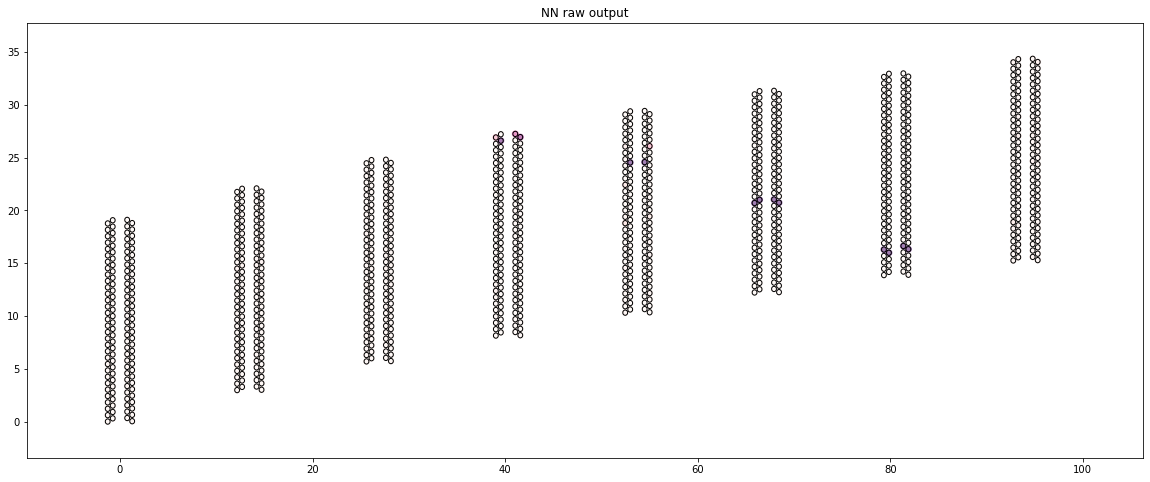

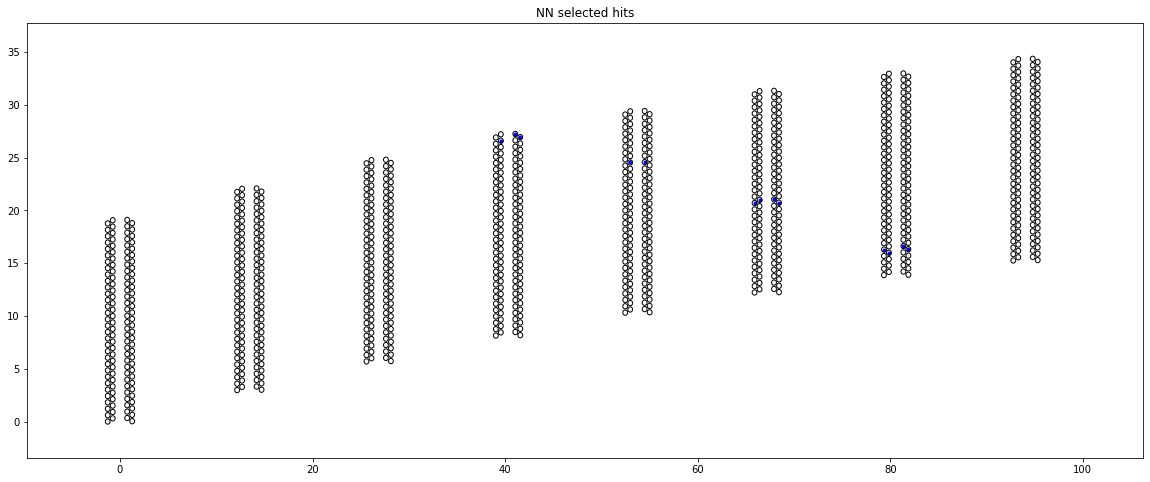

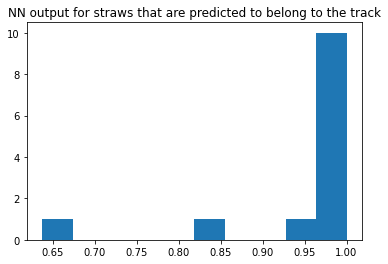

RMS = 0.1027


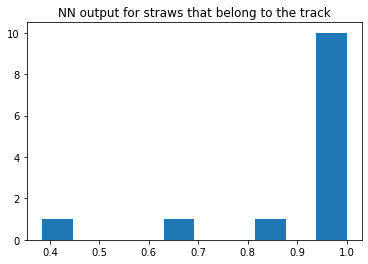

RMS = 0.1836


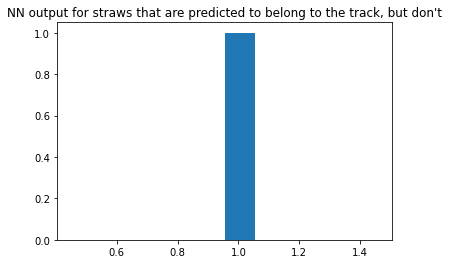

RMS = 0.0000


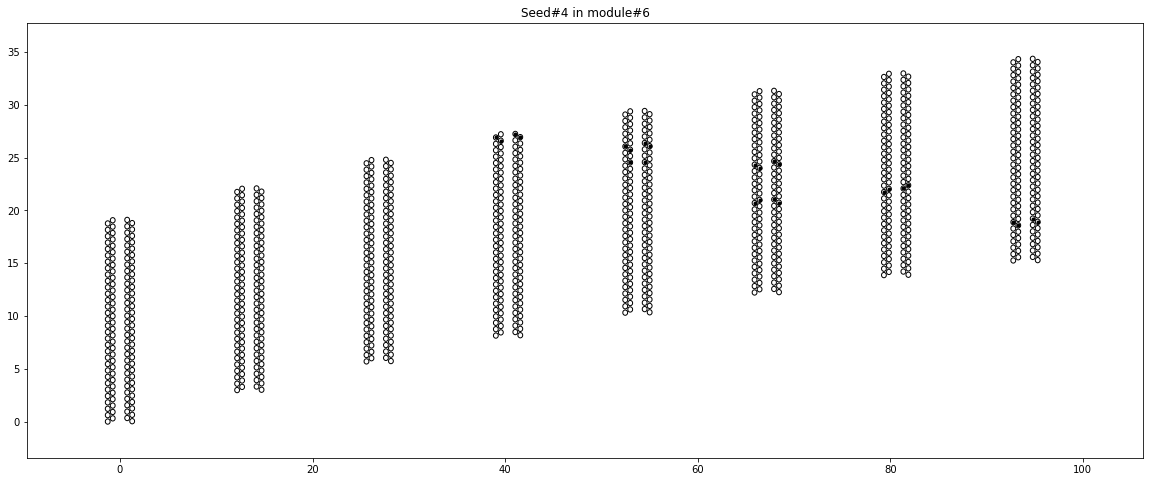

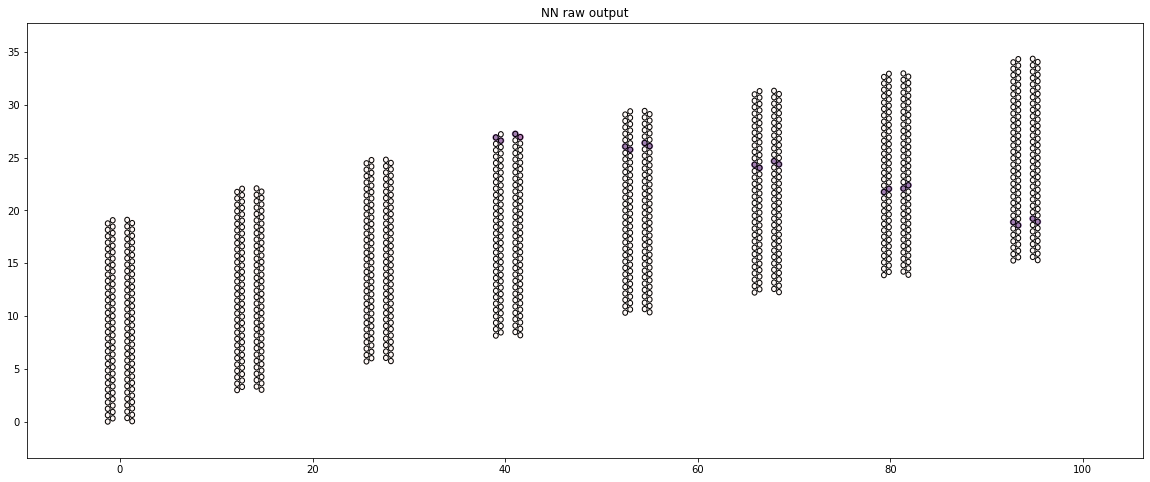

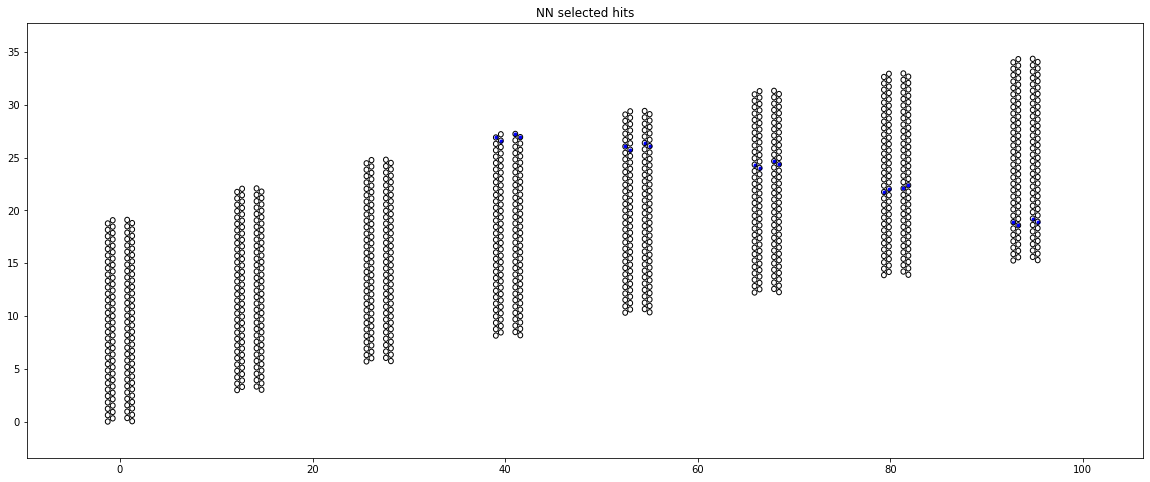

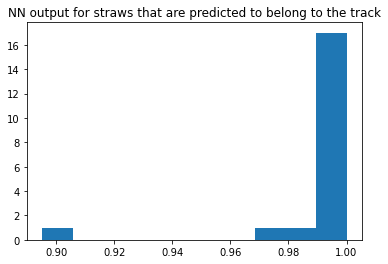

RMS = 0.0231


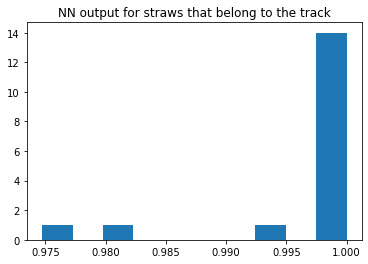

RMS = 0.0071


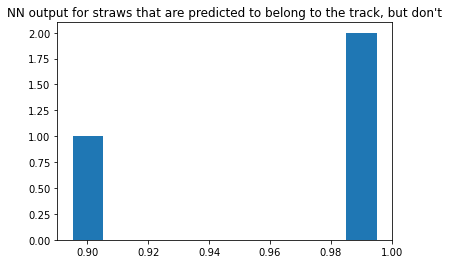

RMS = 0.0460


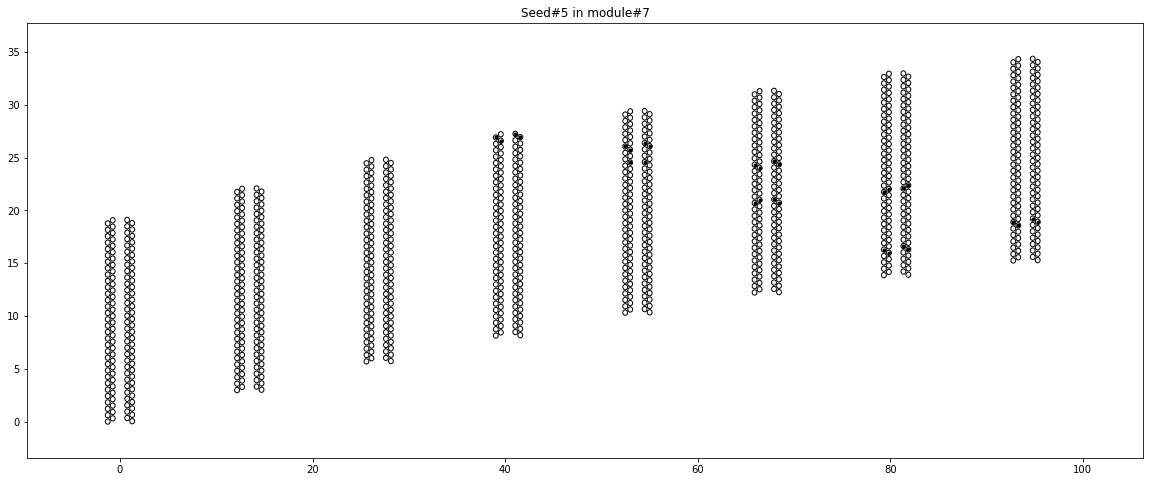

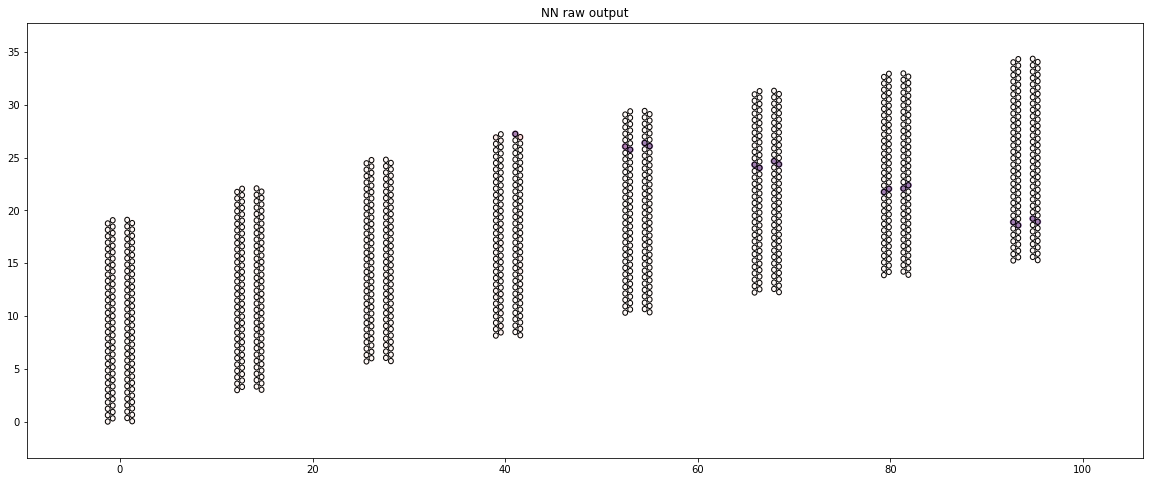

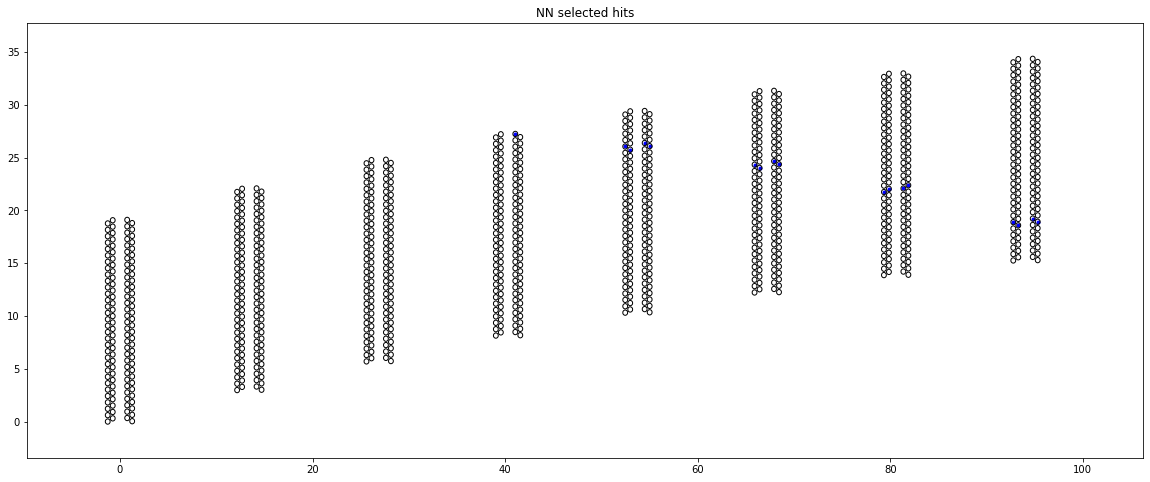

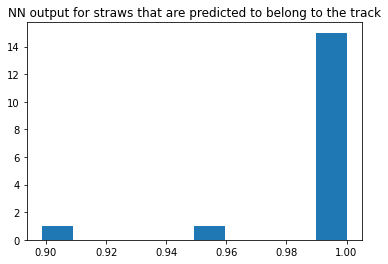

RMS = 0.0256


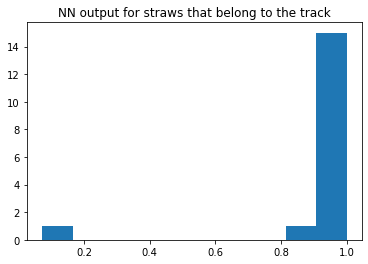

RMS = 0.2181


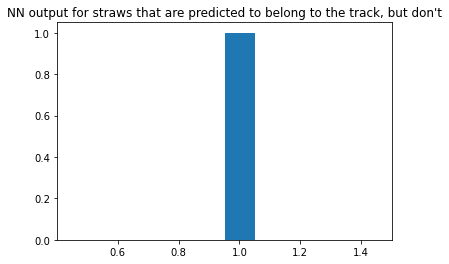

RMS = 0.0000


In [41]:
i_evt=1
plot_event_NNoutput(evts_hits_valid[i_evt],evts_ids_valid[i_evt])

## Accuracy metric on raw NN output

An accuracy metric on the raw NN output, that is more meaningful than the training accuracy.  

Here we define it only based on the accuracy of assigning hits to their tracks. 

In [42]:
def raw_score(evts_hits, evts_ids, selection_threshold=0.7):
    ## Accuracy score for the raw NN output, before any disambiguation step.
    ## Scored per input, how many of the predicted hits actually do belong in the searched track. 
    ## Predicted here just means, those hits with output above the selection threshold.    
    
    ## counters
    n_track_hits, n_predicted, n_correct, n_wrong, seed_accuracy, seed_error = {},{},{},{},{},{}
    for seed_location in ['front','middle','back']:
        n_track_hits[seed_location]=0
        n_predicted[seed_location]=0
        n_correct[seed_location]=0
        n_wrong[seed_location]=0
        seed_accuracy[seed_location]=[]
        seed_error[seed_location]=[]

    ## iterate over all events
    n_evts=evts_hits.shape[0]
    n_print=int(n_evts/10)
    for i_evt in range(n_evts):
        if (i_evt%n_print)==0:
            print('scoring event #%d'%i_evt)
        ## Get all seeds in the event
        seeds_xy, seeds_array=make_real_seeds(evts_ids[i_evt])
        module_seeds_xy={}
        n_seeds={}
        for seed_location in ['front','middle','back']:
            n_seeds[seed_location]=0
        ## Step through each module to count seeds
        for i_module in range(tracker_NN.detector.n_modules):
            if i_module<=2: seed_location='front'
            elif i_module<=5: seed_location='middle'
            else: seed_location='back'
            module_seeds_xy[i_module] = [seed_xy for seed_xy in seeds_xy if (
                (seed_xy[0][0]>=i_module*4) & (seed_xy[0][0]<i_module*4+4) )]
            n_seeds[seed_location] += len(module_seeds_xy[i_module])
        n_seeds_total = n_seeds['front']+n_seeds['middle']+n_seeds['back']
        #print(' Found %d total seeds in the event' % n_seeds_total) 
        if n_seeds_total==0: continue

        ## Format model input for event
        model_input = tracker_NN.prepare_event_for_prediction(evts_hits[i_evt])
                
        ## Get model prediction
        model_prediction={}
        for seed_location in ['front','middle','back']:
            if n_seeds[seed_location]>0:
                model_prediction[seed_location] = tracker_NN.model[seed_location].predict(model_input[seed_location])
            else: model_prediction[seed_location]=None
                
        ### Now step through all seeds from each detector region and score output
        for seed_location in ['front','middle','back']:
            for i_seed in range(n_seeds[seed_location]):

                ## Get the layers/straws for this seed
                seed_layers,seed_straws = np.where(model_input[seed_location][i_seed][:,tracker.n_straws:] == 1)
                track_id = evts_ids[i_evt][seed_layers[0]][seed_straws[0]]
                track_layers,track_straws = np.where(evts_ids[i_evt] == track_id)
                nhits_track = len(track_layers)
                n_track_hits[seed_location]+=nhits_track
                
                ## Now get the track layers/straws that were correctly predicted
                nhits_correct = len(np.where(model_prediction[seed_location][i_seed][track_layers,track_straws]>selection_threshold)[0])
                n_correct[seed_location]+=nhits_correct
                accuracy_score = nhits_correct/nhits_track
                seed_accuracy[seed_location]+=[accuracy_score]
                
                ## Get total predicted hits
                predicted_layers,predicted_straws = np.where(model_prediction[seed_location][i_seed]>selection_threshold)
                nhits_predict = len(predicted_layers)
                n_predicted[seed_location]+=nhits_predict
                
                ## Now get those hits wrongly predicted
                nhits_wrong = len(np.where(evts_ids[i_evt][predicted_layers,predicted_straws]!=track_id)[0])
                n_wrong[seed_location]+=nhits_wrong
                error_score = nhits_wrong/nhits_predict
                seed_error[seed_location]+=[error_score]
      
    
    ## Processed all seeds. Final results:
    for seed_location in ['front','middle','back']:
        print('For %s seeds:'%seed_location)
        print('Total accuracy :: ', n_correct[seed_location]/n_track_hits[seed_location])
        plt.hist(seed_accuracy[seed_location],bins=30)
        plt.show()
        print('Total error :: ', n_wrong[seed_location]/n_track_hits[seed_location])
        plt.hist(seed_error[seed_location],bins=30)
        plt.show()
                
                
            

scoring event #0
scoring event #363
scoring event #726
scoring event #1089
scoring event #1452
scoring event #1815
scoring event #2178
scoring event #2541
scoring event #2904
scoring event #3267
scoring event #3630
For front seeds:
Total accuracy ::  0.9774971616202044


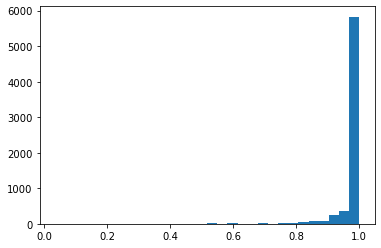

Total error ::  0.02296841434627417


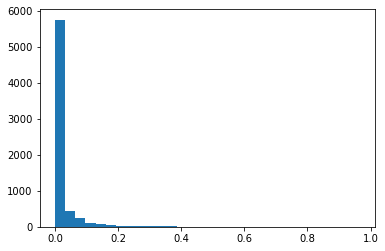

For middle seeds:
Total accuracy ::  0.9765437609445281


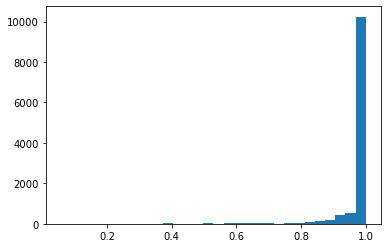

Total error ::  0.026600414972359702


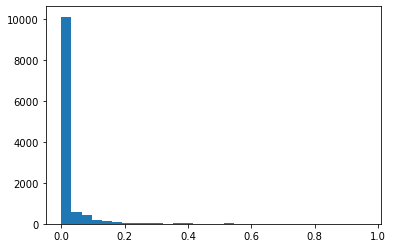

For back seeds:
Total accuracy ::  0.9767419546736773


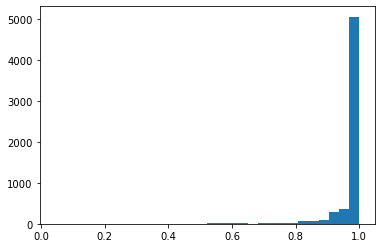

Total error ::  0.024802824739498377


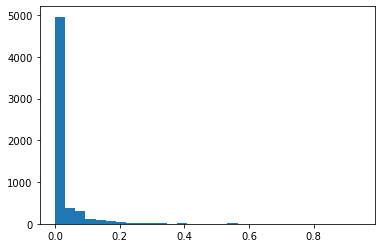

In [43]:
raw_score(evts_hits_valid,evts_ids_valid)

With quick training (12 epochs on ~1000 events -- though scoring partially on training set): 0.82 - 0.88 - 0.79  

With the pre-trained model: 0.86 - 0.82 - 0.79  
(it was ~0.97-0.98 on pseudo-data, so we definitely get a penalty)

Pre-trained, with 30 epochs on ~1000 synthetic events: 0.99 - 0.99 - 0.99  

Trained with Dropout on 800 synthetic events, testing on rest: ~0.93

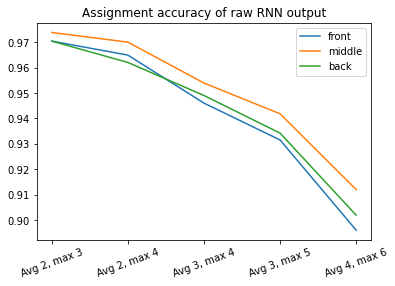

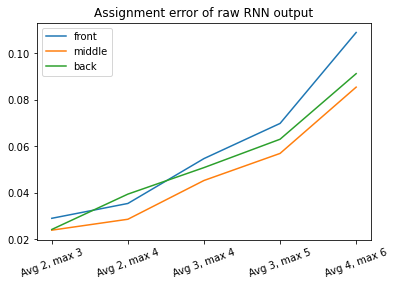

In [17]:
labels=['Avg 2, max 3', 'Avg 2, max 4',  'Avg 3, max 4', 'Avg 3, max 5', 'Avg 4, max 6']

raw_acc={}
raw_acc['front']  = [0.9704,0.9649,0.946,0.9315,0.896]
raw_acc['middle'] = [0.9738, 0.970,0.9539,0.9418,0.912]
raw_acc['back']   = [0.9704,0.962,0.949,0.9342,0.9019]

raw_err={}
raw_err['front']  = [0.029,0.03538,0.05468,0.0698,0.1089]
raw_err['middle'] = [0.0239,0.02859,0.04526,0.0569,0.0854]
raw_err['back']   = [0.0242,0.0394,0.0508,0.063,0.0912]


for seed_location in ['front','middle','back']:
    plt.plot(raw_acc[seed_location], label=seed_location)
plt.title('Assignment accuracy of raw RNN output')
plt.xticks(np.arange(5), labels, rotation=20)  # Set text labels and properties.
plt.legend()
plt.show()
for seed_location in ['front','middle','back']:
    plt.plot(raw_err[seed_location], label=seed_location)
plt.title('Assignment error of raw RNN output')
plt.xticks(np.arange(5), labels, rotation=20)  # Set text labels and properties.
plt.legend()
plt.show()

## Complete event prediction

Using the NN output, define an algorithm to give a complete event prediction for hits that belong in the same track.

In [44]:
### Identify "golden" seeds that give great track candidates.
### Assume that all their hits are correct, therefore:
### * merge their seeds with other seeds that were included in the golden track hits
### * remove golden track hits from other seeds input


def merge_golden_seeds(model_input, #looseness, #model_prediction=np.array(0),
                       removed_seed_ids, good_track_ids ):    

    #print('\n\n Merging golden seeds\n')
    #print('removed_seed_ids : ', removed_seed_ids)
    #print('good_track_ids : ', good_track_ids)
    
    n_seeds={}
    for seed_location in ['front','middle','back']:
        n_seeds[seed_location]=model_input[seed_location].shape[0]
    n_seeds_total=n_seeds['front']+n_seeds['middle']+n_seeds['back']
    if n_seeds_total==0: # no disambiguation needed
        #print('\nOnly %d seeds in model input\n' % n_seeds)
        return model_input, np.nan, 0, 0
    ## assign an ID to each seed, so that we can combine and delete them
    seed_ids=np.arange(n_seeds_total)
    
    selection_threshold = 0.7# + looseness*0.07

    ### Get model prediction    
    model_prediction_full = np.zeros( (n_seeds_total, tracker.n_layers, tracker.n_straws) )
    if n_seeds['front']>0: model_prediction_full[:n_seeds['front']] = tracker_NN.model['front'].predict(model_input['front'])
    if n_seeds['middle']>0: model_prediction_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']] = tracker_NN.model['middle'].predict(model_input['middle'])
    if n_seeds['back']>0: model_prediction_full[n_seeds['front']+n_seeds['middle']:] = tracker_NN.model['back'].predict(model_input['back'])

    ## Make model input array of same shape, for ease of operations
    model_input_full = np.zeros( (n_seeds_total, tracker_NN.detector.n_layers, 2*tracker_NN.detector.n_straws) )
    model_input_full[:n_seeds['front']] = model_input['front']
    model_input_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']] = model_input['middle']
    model_input_full[n_seeds['front']+n_seeds['middle']:] = model_input['back']

    ## First set all straws that weren't hit to 0
    model_prediction_full[np.where((model_input_full[:,:,:tracker_NN.detector.n_straws]==0))] = 0
    model_prediction_selected = np.zeros_like(model_prediction_full)
    model_prediction_selected[np.where(model_prediction_full>selection_threshold)] = 1
    
    ## indicator whether input was modified
    modified_input=0
    
    ## go through all seeds, search for "golden" tracks
    for seed_id in seed_ids:
        if seed_id in removed_seed_ids: continue
        #print('processing seed id #', seed_id)

        layers,straws=np.where(model_input_full[seed_id]==1)
        seed_layers=layers[straws>=tracker_NN.detector.n_straws]
        seed_straws=straws[straws>=tracker_NN.detector.n_straws] - tracker_NN.detector.n_straws
        predicted_layers,predicted_straws=np.where(model_prediction_selected[seed_id]==1)
        n_predicted_hits = len(predicted_layers)
        if n_predicted_hits<6: continue

        prediction_min = min(    model_prediction_full[seed_id][predicted_layers,predicted_straws] )
        prediction_rms = np.std( model_prediction_full[seed_id][predicted_layers,predicted_straws] )
        nhits_track    = np.sum( model_prediction_selected[seed_id][predicted_layers,predicted_straws] )

        #print('min prediction = ', prediction_min)
        #print('rms prediction = ', prediction_rms)
        #print('nhits_track = ', nhits_track)

        golden_threshold = 0.98# - looseness*0.02
        if (prediction_min>golden_threshold):# & (prediction_rms<0.005) & (nhits_track>=6):
            ## Very good track, likely with all predicted hits correct            
            if not (seed_id in good_track_ids):
                #print('Accepting GOLDEN track with seed id #%d\n'%seed_id)
                good_track_ids += [seed_id]
                modified_input=1

            ## Step through all other seeds, search for ones that belong to the same track
            for seed_id2 in seed_ids:
                if seed_id2 == seed_id: continue
                if seed_id2 in removed_seed_ids: continue

                layers2,straws2=np.where(model_input_full[seed_id2]==1)
                seed_layers2=layers2[straws2>=tracker_NN.detector.n_straws]
                seed_straws2=straws2[straws2>=tracker_NN.detector.n_straws] - tracker_NN.detector.n_straws

                ## number of seed hits of seed_id2 that were selected in seed_id
                n_seed_same = np.sum( model_prediction_selected[seed_id][seed_layers2,seed_straws2] )
                ## number and fraction of common selected hits overall
                n_hits_same = np.sum( model_prediction_selected[seed_id2][predicted_layers,predicted_straws] )
                frac_hits_same = n_hits_same / n_predicted_hits

                #print('Cross-checking with seed #',seed_id2)
                #print('%d same seed hits '%n_seed_same)
                #print('%d same hits overall '%n_hits_same)
                #print('%dpc fractional same hits '%(100*frac_hits_same))

                if (n_seed_same>=2) & (n_hits_same>=4):
                    ## Since the original seed is high purity, assume that this seed is part of the same track.
                    ## Remove this seed_id2 from further consideration
                    #print('Merging seed#%d into seed#%d'%(seed_id2,seed_id))
                    removed_seed_ids += [seed_id2]
                    ## previously was turning on all merged seed hits; but probably not wise without dedicated training for that
                    ##model_input_full[seed_id][seed_layers2,seed_straws2] = 1
                    ## Only keep one seed. Make sure to keep the seed from earlier layers:
                    if seed_layers2[0]<seed_layers[0]:
                        ## use seed2 instead; turn off original seeds
                        model_input_full[seed_id][seed_layers2,seed_straws2] = 1
                        model_input_full[seed_id][seed_layers,seed_straws] = 0
                        ## for this comparison with other seeds, update seed_layers[0] -- it's not needed otherwise
                        seed_layers[0] = seed_layers2[0]
                    modified_input=1



            ## We assume that all its predicted hits are correct here, and remove them from all other inputs
            ## - we need to do this only after we look for shared hits with other seeds to merge
            for seed_id2 in seed_ids:
                if (seed_id2 == seed_id) or (seed_id2 in removed_seed_ids): continue
                if any(model_input_full[seed_id2][predicted_layers,predicted_straws]>0 ):
                    model_input_full[seed_id2][predicted_layers,predicted_straws]=0
                    modified_input=1

            #print(' Good track identified:: ')
            #display_event(tracker, straw_hits=model_prediction_selected[seed_id])        

    ## Recover partial inputs from each seed location
    model_input['front'] = model_input_full[:n_seeds['front']]
    model_input['middle'] = model_input_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']]
    model_input['back'] = model_input_full[n_seeds['front']+n_seeds['middle']:]

    
    
    return model_input, removed_seed_ids, good_track_ids, modified_input




In [45]:
### Identify "silver" seeds that give good track candidates, but don't assume that all their hits are correct.
### Call with increasingly loose criteria.
### * merge with other seeds that have enough shared hits
### * remove the most reliable silver hits from other seeds input 
###   ** (provided they don't also have high output in other seeds)


def merge_silver_seeds(model_input, looseness, #model_prediction=np.array(0),
                       removed_seed_ids, good_track_ids):    

    #print('\n\n Merging silver seeds\n')
    #print('removed_seed_ids : ', removed_seed_ids)
    #print('good_track_ids : ', good_track_ids)
    
    n_seeds={}
    for seed_location in ['front','middle','back']:
        n_seeds[seed_location]=model_input[seed_location].shape[0]
    n_seeds_total=n_seeds['front']+n_seeds['middle']+n_seeds['back']
    if n_seeds_total==0: # no disambiguation needed
        #print('\nOnly %d seeds in model input\n' % n_seeds)
        return model_input, np.nan, 0, 0
    ## assign an ID to each seed, so that we can combine and delete them
    seed_ids=np.arange(n_seeds_total)
        
    ### Get model prediction    
    model_prediction_full = np.zeros( (n_seeds_total, tracker_NN.detector.n_layers, tracker_NN.detector.n_straws) )
    if n_seeds['front']>0: model_prediction_full[:n_seeds['front']] = tracker_NN.model['front'].predict(model_input['front'])
    if n_seeds['middle']>0: model_prediction_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']] = tracker_NN.model['middle'].predict(model_input['middle'])
    if n_seeds['back']>0: model_prediction_full[n_seeds['front']+n_seeds['middle']:] = tracker_NN.model['back'].predict(model_input['back'])

    ## Make model input array of same shape, for ease of operations
    model_input_full = np.zeros( (n_seeds_total, tracker_NN.detector.n_layers, 2*tracker_NN.detector.n_straws) )
    model_input_full[:n_seeds['front']] = model_input['front']
    model_input_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']] = model_input['middle']
    model_input_full[n_seeds['front']+n_seeds['middle']:] = model_input['back']
    
    ## Selection based on prediction
    selection_threshold=0.7 #+ looseness*0.05
    ## First set all straws that weren't hit to 0
    model_prediction_full[np.where((model_input_full[:,:,:tracker_NN.detector.n_straws]==0))] = 0
    model_prediction_selected = np.zeros_like(model_prediction_full)
    model_prediction_selected[np.where(model_prediction_full>selection_threshold)] = 1
    
    ## indicator whether input was modified
    modified_input=0
    
    ## go through all seeds, search for "silver" quality
    for seed_id in seed_ids:
        if seed_id in removed_seed_ids: continue
        #print('processing seed id #', seed_id)

        layers,straws=np.where(model_input_full[seed_id]==1)
        seed_layers=layers[straws>=tracker_NN.detector.n_straws]
        seed_straws=straws[straws>=tracker_NN.detector.n_straws] - tracker_NN.detector.n_straws
        predicted_layers,predicted_straws=np.where(model_prediction_selected[seed_id]==1)
        n_predicted_hits = len(predicted_layers)        
        
        ## if too few good hits, remove seed
        if n_predicted_hits<4:
            if looseness>2: 
                removed_seed_ids += [seed_id]
                modified_input=1
            continue
  
        ### Turn off all the hits that had output below a cutoff (increasing with looseness)
        ### from the input of this same seed     
        for i,ilayer in enumerate(layers):
            istraw = straws[i]
            if istraw>=tracker_NN.detector.n_straws: continue
            cutoff=looseness*0.02
            if (model_prediction_full[seed_id][ilayer][istraw]<cutoff):
                #print('Removing hit at (%d,%d)' % (ilayer,istraw))
                model_input_full[seed_id][ilayer][istraw] = 0          
                modified_input=1
        
        
        prediction_min = min(    model_prediction_full[seed_id][predicted_layers,predicted_straws] )
        prediction_rms = np.std( model_prediction_full[seed_id][predicted_layers,predicted_straws] )
        nhits_track    = np.sum( model_prediction_selected[seed_id][predicted_layers,predicted_straws] )

        #print('min prediction = ', prediction_min)
        #print('rms prediction = ', prediction_rms)
        #print('nhits_track = ', nhits_track)

        silver_threshold = 0.93 - looseness*0.03
        if (prediction_min>silver_threshold):# & (prediction_rms<0.005) & (nhits_track>=6):
            ## Good track, but still some ambiguity
            ## don't assume that all its hits are necessarily correct
            if not (seed_id in good_track_ids):
                #print('Accepting SILVER track with seed id #%d\n'%seed_id)
                good_track_ids += [seed_id]
                modified_input=1
            
            ## Now step through all other seeds, search for ones that belong to the same track
            merged_seeds=[seed_id]
            for seed_id2 in seed_ids:
                if (seed_id2 in removed_seed_ids): continue

                layers2,straws2=np.where(model_input_full[seed_id2]==1)
                seed_layers2=layers2[straws2>=tracker_NN.detector.n_straws]
                seed_straws2=straws2[straws2>=tracker_NN.detector.n_straws] - tracker_NN.detector.n_straws

                ## number of seed hits of seed_id2 that were selected in seed_id
                n_seed_same = np.sum( model_prediction_selected[seed_id][seed_layers2,seed_straws2] )
                ## number and fraction of common selected hits overall
                n_hits_same = np.sum( model_prediction_selected[seed_id2][predicted_layers,predicted_straws] )
                frac_hits_same = n_hits_same / n_predicted_hits

                #print('Cross-checking with seed #',seed_id2)
                #print('%d same seed hits '%n_seed_same)
                #print('%d same hits overall '%n_hits_same)
                #print('%dpc fractional same hits '%(100*frac_hits_same))

                if (n_seed_same>=2) & (n_hits_same>=5-looseness*0.4):
                    ## Since the original seed is of good quality, we assume that this seed is part of the same track.
                    ## Remove this seed_id2 from further consideration.
                    ## We still don't assume that all its hits are correctly assigned
                    #print('Merging seed#%d into seed#%d'%(seed_id2,seed_id))
                    merged_seeds += [seed_id2]
                    removed_seed_ids += [seed_id2]
                    ## previously was turning on all merged seed hits; but probably not wise without dedicated training for that
                    ##model_input_full[seed_id][seed_layers2,seed_straws2+tracker_NN.detector.n_straws] = 1
                    modified_input=1



            ## Find the highest quality hits among the merged seeds
            for i,ilayer in enumerate(predicted_layers):
                istraw = predicted_straws[i]
                ## this hit is high-quality if its output is high enough among all merged seeds
                ## or at least nmin merged seeds find it to be high
                high_threshold=0.98 - looseness*0.01
                if np.sum(model_prediction_full[merged_seeds, ilayer, istraw]>high_threshold)>=3:
                    #print('Good hit at (%d,%d)' % (ilayer,istraw))
                    ## Set it to 0 at other inputs, except if other seeds have selected it with high-ish output also
                    for seed_id2 in seed_ids:
                        if ((seed_id2 in good_track_ids) 
                            or (seed_id2 in removed_seed_ids) ): continue
                        if model_prediction_full[seed_id2][ilayer][istraw]<0.8:
                            model_input_full[seed_id2][ilayer][istraw] = 0
                    modified_input=1

            #print(' Good track identified:: ')
            #display_event(tracker, straw_hits=model_prediction_selected[seed_id])        

            
    ## Recover partial inputs from each seed location
    model_input['front'] = model_input_full[:n_seeds['front']]
    model_input['middle'] = model_input_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']]
    model_input['back'] = model_input_full[n_seeds['front']+n_seeds['middle']:]


    return model_input, removed_seed_ids, good_track_ids, modified_input





In [46]:
def get_prediction_selected(model_input, selection_threshold):  

    ## Beware: This function washes away the seed location information.
    ## Apply it only as a last step.
    
    #print('\n Now in get_prediction_selected script\n')
    
    n_seeds={}
    for seed_location in ['front','middle','back']:
        n_seeds[seed_location]=model_input[seed_location].shape[0]
    n_seeds_total=n_seeds['front']+n_seeds['middle']+n_seeds['back']
    if n_seeds_total==0: # no disambiguation needed
        #print('\nOnly %d seeds in model input\n' % n_seeds)
        return model_input, np.nan, 0, 0
    #print('nseeds : ',n_seeds)
    ## assign an ID to each seed, so that we can combine and delete them
    seed_ids=np.arange(n_seeds_total)
        
    ### Get model prediction    
    model_prediction_full = np.zeros( (n_seeds_total, tracker_NN.detector.n_layers, tracker_NN.detector.n_straws) )
    if n_seeds['front']>0: model_prediction_full[:n_seeds['front']] = tracker_NN.model['front'].predict(model_input['front'])
    if n_seeds['middle']>0: model_prediction_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']] = tracker_NN.model['middle'].predict(model_input['middle'])
    if n_seeds['back']>0: model_prediction_full[n_seeds['front']+n_seeds['middle']:] = tracker_NN.model['back'].predict(model_input['back'])

    ## Make model input array of same shape, for ease of operations
    model_input_full = np.zeros( (n_seeds_total, tracker_NN.detector.n_layers, 2*tracker_NN.detector.n_straws) )
    model_input_full[:n_seeds['front']] = model_input['front']
    model_input_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']] = model_input['middle']
    model_input_full[n_seeds['front']+n_seeds['middle']:] = model_input['back']
    
    ## Selection based on prediction
    ## First set all straws that weren't hit to 0
    model_prediction_full[np.where((model_input_full[:,:,:tracker_NN.detector.n_straws]==0))] = 0
    model_prediction_selected = np.zeros_like(model_prediction_full)
    model_prediction_selected[np.where(model_prediction_full>selection_threshold)] = 1
    
    
    return model_prediction_selected
    
    

In [47]:
def get_prediction_ids(model_prediction_selected):    
    ## Get model prediction ids in a single array of dimensions [length,width]
    prediction_ids = np.zeros((n_layers,n_straws))
    for i_track in range(model_prediction_selected.shape[0]):
        layers,straws = np.where(model_prediction_selected[i_track]==1)
        prediction_ids[layers,straws] = i_track+1        
    return prediction_ids
    
    

In [48]:
### Disambiguate hits that are selected by multiple tracks


def disambiguate_hits(model_input, good_seed_ids, selection_threshold):   
    #print('\n\n Disambiguating hits\n')
    
    n_seeds={}
    for seed_location in ['front','middle','back']:
        n_seeds[seed_location]=model_input[seed_location].shape[0]
    n_seeds_total=n_seeds['front']+n_seeds['middle']+n_seeds['back']
    if n_seeds_total<=1: # no disambiguation needed
        #print('\nOnly %d seeds in model input\n' % n_seeds)
        return model_input
    ## assign an ID to each seed, so that we can combine and delete them
    seed_ids=np.arange(n_seeds_total)
        
    ### Get model prediction    
    model_prediction_full = np.zeros( (n_seeds_total, tracker_NN.detector.n_layers, tracker_NN.detector.n_straws) )
    if n_seeds['front']>0: model_prediction_full[:n_seeds['front']] = tracker_NN.model['front'].predict(model_input['front'])
    if n_seeds['middle']>0: model_prediction_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']] = tracker_NN.model['middle'].predict(model_input['middle'])
    if n_seeds['back']>0: model_prediction_full[n_seeds['front']+n_seeds['middle']:] = tracker_NN.model['back'].predict(model_input['back'])

    ## Make model input array of same shape, for ease of operations
    model_input_full = np.zeros( (n_seeds_total, tracker_NN.detector.n_layers, 2*tracker_NN.detector.n_straws) )
    model_input_full[:n_seeds['front']] = model_input['front']
    model_input_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']] = model_input['middle']
    model_input_full[n_seeds['front']+n_seeds['middle']:] = model_input['back']

    ## Selection based on prediction
    ## First set all straws that weren't hit to 0
    model_prediction_full[np.where((model_input_full[:,:,:tracker_NN.detector.n_straws]==0))] = 0
    model_prediction_selected = np.zeros_like(model_prediction_full)
    model_prediction_selected[np.where(model_prediction_full>selection_threshold)] = 1

    
    ## go through all good seeds, search for doubly assigned hits
    for seed_id in good_seed_ids:
        #print('processing seed id #', seed_id)

        predicted_layers,predicted_straws=np.where(model_prediction_selected[seed_id]==1)
        n_predicted_hits = len(predicted_layers)

        for i,ilayer in enumerate(predicted_layers):
            istraw = predicted_straws[i]
            hit_output_value = model_prediction_full[seed_id][ilayer][istraw]
            ## Go through other seeds, check for other seeds that selected this hit
            for seed_id2 in good_seed_ids:
                if (seed_id2 == seed_id): continue
                if model_prediction_full[seed_id2][ilayer][istraw]>hit_output_value:
                    model_input_full[seed_id][ilayer][istraw] = 0
                else: 
                    model_input_full[seed_id2][ilayer][istraw] = 0
                #print('Disambiguating hit (%d,%d) between seeds %d-%d' % (ilayer,istraw,seed_id,seed_id2) )

                       
    ## Recover partial inputs from each seed location
    model_input['front'] = model_input_full[:n_seeds['front']]
    model_input['middle'] = model_input_full[n_seeds['front']:n_seeds['front']+n_seeds['middle']]
    model_input['back'] = model_input_full[n_seeds['front']+n_seeds['middle']:]

    return model_input






In [49]:
def merge_seeds(evt_hits):
    '''
    Iteratively go over input for all seeds, merging them into tracks
    and disambiguating difficult hits
    '''
    
    ## Format model input for event
    model_input = tracker_NN.prepare_event_for_prediction(evt_hits)
    n_seeds_total = model_input['front'].shape[0]+model_input['middle'].shape[0]+model_input['back'].shape[0]

    '''
    Ideas to consider:

    * Extract directionality of each track candidate and seeds.
        ** Can use that information to exclude some hit outliers, changes in track direction, or veto some seed combinations.
        ** OTOH, this is too "algorithmic". That information should in principle have been "learnt" by the NN.

    * First identify very good tracks
        ** They will have a high fraction of high-probability hits, and low variance in directionality
            *** We need this metric to be 100% "golden".
            *** If not (eg not fully accurate tracks still get golden output) then make loss function stricter
        ** Merge with other seeds that are included in the golden hits
            *** May mark those other seeds as seeds in the golden track
            *** Then run the track again through the NN, perhaps can gain something with more constraints
            *** Though the NN hasn't been trained to run with seeds in many modules
        ** Then remove the hits of good tracks from all other inputs, making all other tracks much more tractable
        ** Then pass everything through the NN in a second (and more simplified) pass, get better results

    * Then start merging seeds between non-golden tracks
        ** Require a certain number/fraction of shared hits
        ** This might get messy, considering that late seeds have poor output
            *** If the output of a seed looks bad at this point (under some criteria) then just drop it.
            *** Its hits are probably contained in the track of an earlier seed anyway

    * Lastly, disambiguate hits that are shared between tracks
        ** Based on the NN outputs
        
    '''
    looseness = 0
    removed_seed_ids=[]
    good_track_ids=[]
    while (looseness<4):
        ## iterate with increasing looseness

        ## Look for golden tracks, merge their seeds, remove their hits from other inputs
        ## This should iterative, until no new golden tracks found, or any modification in input made
        modified_input=0
        while(1):
            model_input, removed_seed_ids, good_track_ids, modified_input = merge_golden_seeds(model_input,
                                                                               removed_seed_ids=removed_seed_ids,
                                                                               good_track_ids=good_track_ids)
            if ((modified_input==0) or (removed_seed_ids is not np.nan) ): break
        ### Are we done?
        if removed_seed_ids is np.nan:
            #print('Hold up, only 1 or 0 seeds in event')
            return 0, 0
        if (n_seeds_total-len(removed_seed_ids) == len(good_track_ids) ):
            #print('Found all good tracks !!')
            return model_input, good_track_ids


        ## Now look for silver tracks
        ## After each "silver" search we go back to looking for gold
        model_input, removed_seed_ids, good_track_ids, modified_input = merge_silver_seeds(model_input, looseness=looseness,
                                                                           removed_seed_ids=removed_seed_ids, 
                                                                           good_track_ids=good_track_ids)
        if removed_seed_ids is np.nan:
            #print('Hold up, only 1 or 0 seeds in event')
            return model_input, 0
        if (n_seeds_total-len(removed_seed_ids) == len(good_track_ids) ):
            #print('Found all good tracks!!')
            return model_input, good_track_ids

        ## loosen criteria for next iteration
        looseness+=1

    ## if we make it out here without final solution, then just return the good tracks we found already
    return model_input, good_track_ids


In [50]:
## here duplicate functionality of fully predicting an event,
## including disambiguating the NN output iteratively

def predict_event(evt_hits):
    """
    Note that input and prediction are expected to be both for a single event, 
    potentially with many tracks and seeds.
    The first dimension is equal to the number of seeds in the event. 
    * Set all straws that weren't hit to 0
    * Check whether some seeds can be combined into a single track
    * Pass the combined seeds through a (new?) track search
    * Disambiguate straw hits that are assigned to multiple tracks
    * Round probabilistic track assignment to binary yes/no
    * Return the prediction for tracks in the event
    Note that the return prediction matrix will be of smaller dimension than the input
    """ 

    ### Create model input, iteratively merge seeds
    model_input, good_seed_ids = merge_seeds(evt_hits)
    if (np.all(model_input==0)) or (len(good_seed_ids)==0): return np.zeros_like(evt_hits)


    ### Lastly, disambiguate hits that are selected in multiple tracks
    model_input = disambiguate_hits(model_input=model_input, good_seed_ids=good_seed_ids,
                                    selection_threshold = 0.9)


    ### Should be done here!
    ### Get final prediction and selection
    model_prediction_selected = get_prediction_selected(model_input=model_input,
                                                        selection_threshold=0.8) 

    ### Chop down to just the good seeds
    model_prediction_selected = model_prediction_selected[good_seed_ids,:,:]    


    prediction_ids = get_prediction_ids(model_prediction_selected)


    return prediction_ids



In [51]:

def predict_events(evts_hits):
    """
    Fully predict many events, by calling predict_event on each.
    Return a predictions_ids array of dimensions (n_evts, n_layers, n_straws)
    """ 

    predictions_ids=np.zeros_like(evts_hits)
    n_evts=evts_hits.shape[0]   
    n_print=int(n_evts/10.)
    for i_evt in range(n_evts):
        if (i_evt%n_print)==0: print('predicting event #%d'%i_evt)
        evt_hits=evts_hits[i_evt]
        predictions_ids[i_evt] = predict_event(evt_hits)
    return predictions_ids


In [52]:
      
def plot_event_and_prediction(evt_hits, evt_ids=False, figsize=(15,10)):
    
    
    if evt_ids is False:
        print('Event hits:')
        display_event(tracker, evt_hits)
    else:
        print('Event truth:')
        display_event(tracker, evt_hits, evt_ids)


    ## Get model prediction
    prediction_ids = predict_event(evt_hits)
    if np.all(prediction_ids==0): 
        print('Skipping...')
        return        
    print('\nModel prediction:')    
    
    full_detector_width = tracker_NN.detector.width

    fig, axs = plt.subplots(figsize=figsize)        
    ## First, plot the model input in the left subplot
    axs.set_title('Model prediction')

    axs.set_xlim((-0.1*tracker_NN.detector.length, 1.1*tracker_NN.detector.length))
    axs.set_ylim((-0.1*full_detector_width, 1.1*full_detector_width))

    # plot a circle at the location of each straw
    for ilayer,straw_x in enumerate(tracker_NN.detector.x):
        for straw_y in tracker_NN.detector.y[ilayer]:
            circle = plt.Circle((straw_x, straw_y), tracker_NN.detector.straw_radius, color='black', fill=False)
            axs.add_patch(circle)

    # plot the model prediction for each track
    track_ids=np.unique(prediction_ids[np.where(prediction_ids>0)])
    for i_track in track_ids:              
        track_x,track_y=np.where(prediction_ids==i_track)#self.detector.n_straws]==1)
        axs.scatter(tracker_NN.detector.x[track_x],tracker_NN.detector.y[track_x,track_y], marker='o', #color='black',
                    label='track %d'%(i_track))            
            
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.show()





 Event # 3
Event truth:


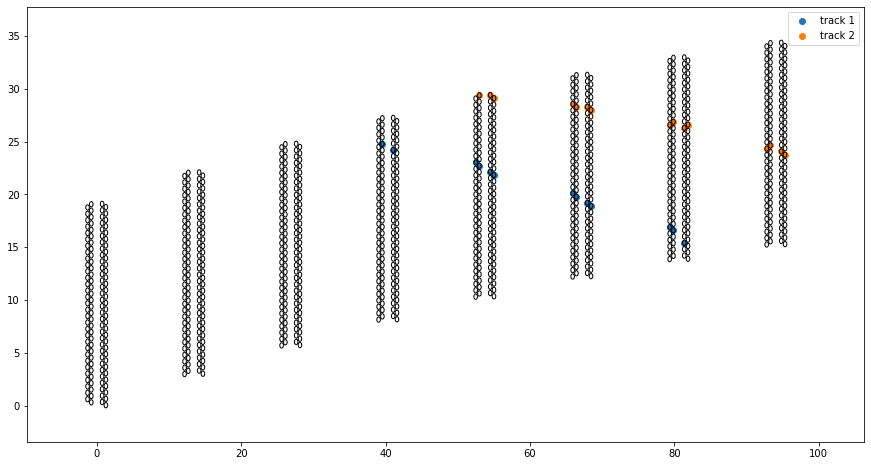


Model prediction:


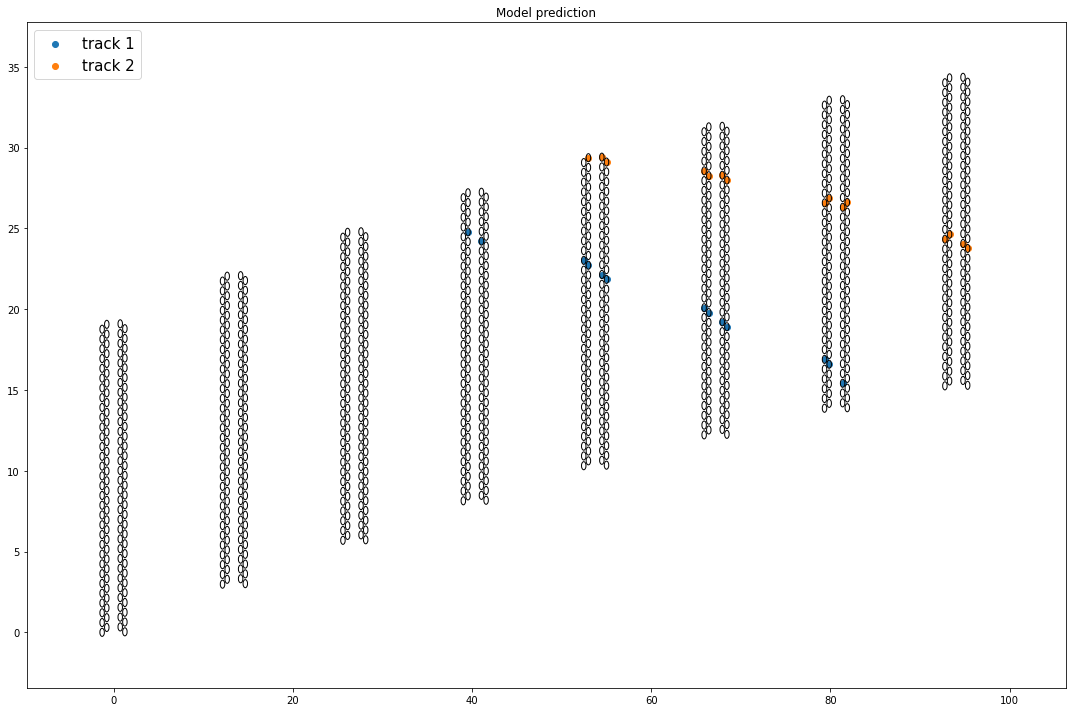

 Event # 4
Event truth:


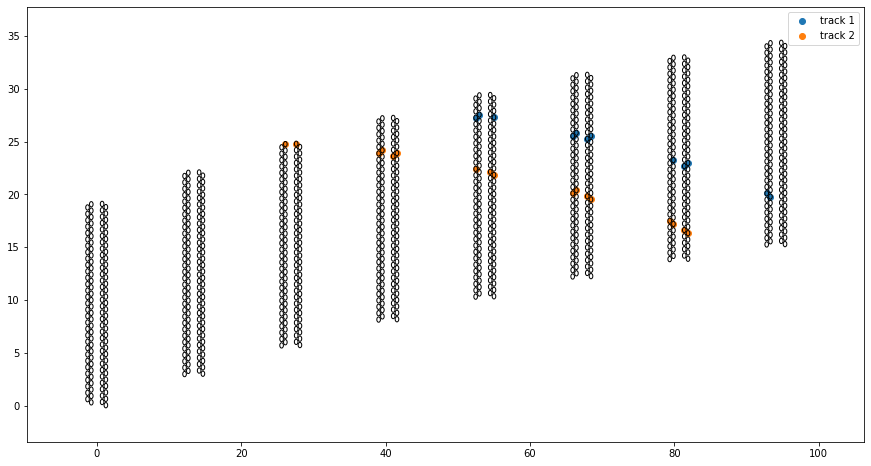


Model prediction:


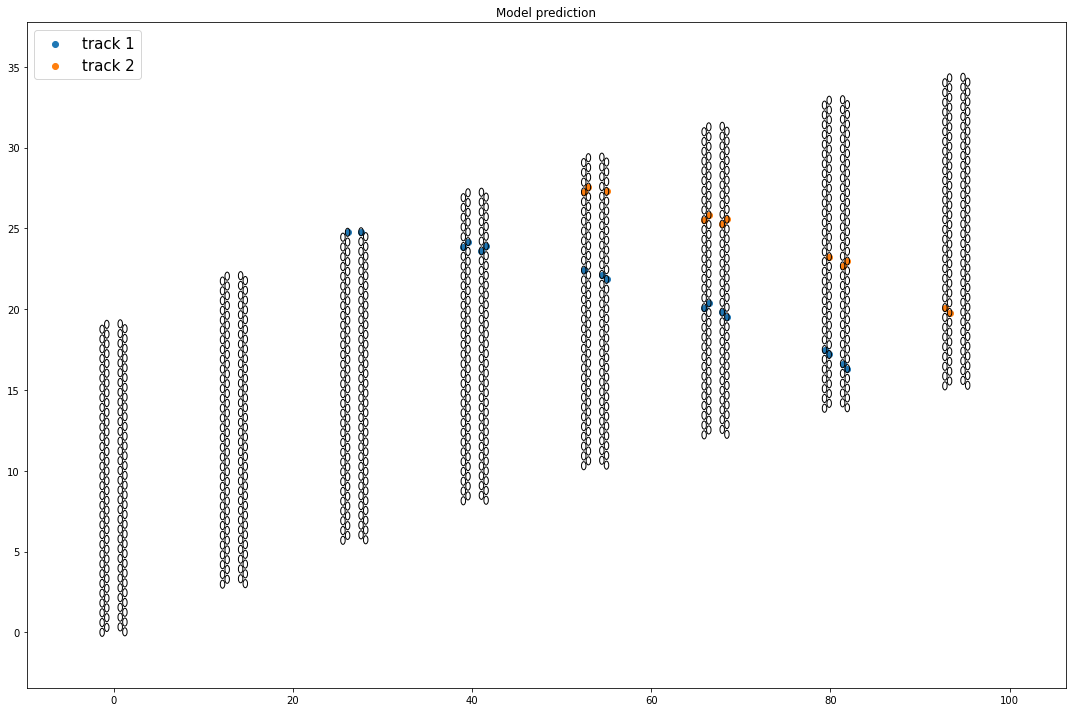

 Event # 5
Event truth:


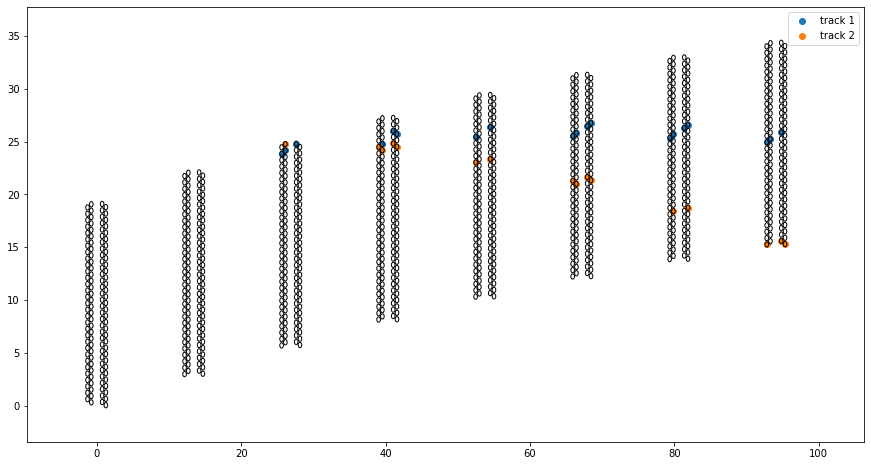


Model prediction:


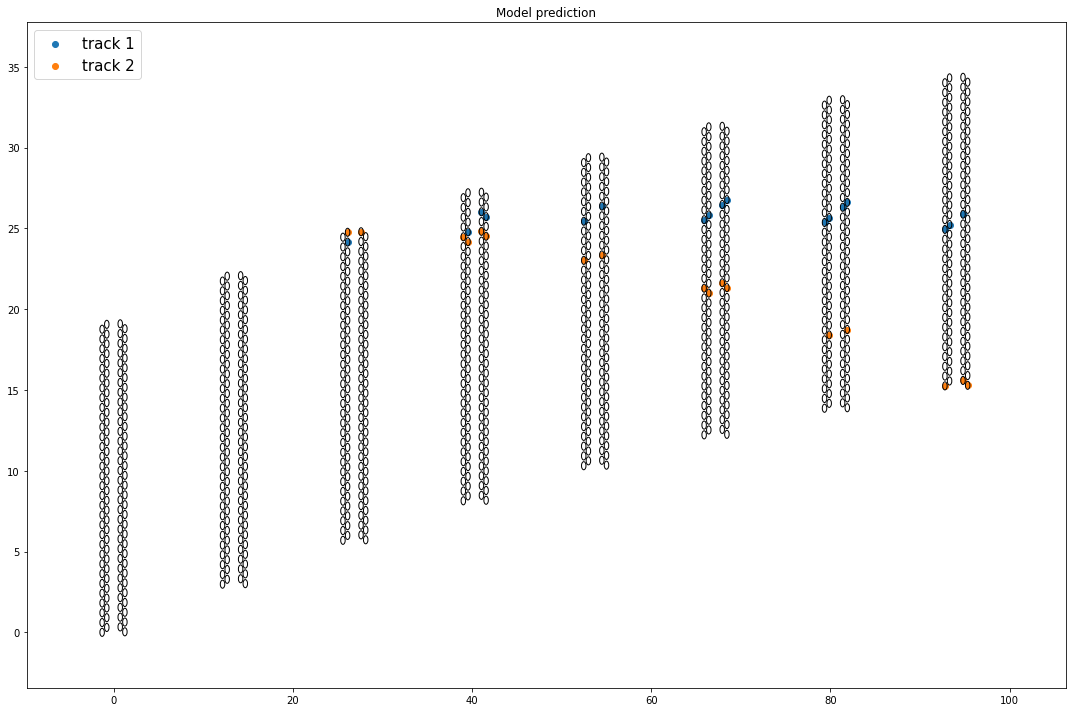

 Event # 6
Event truth:


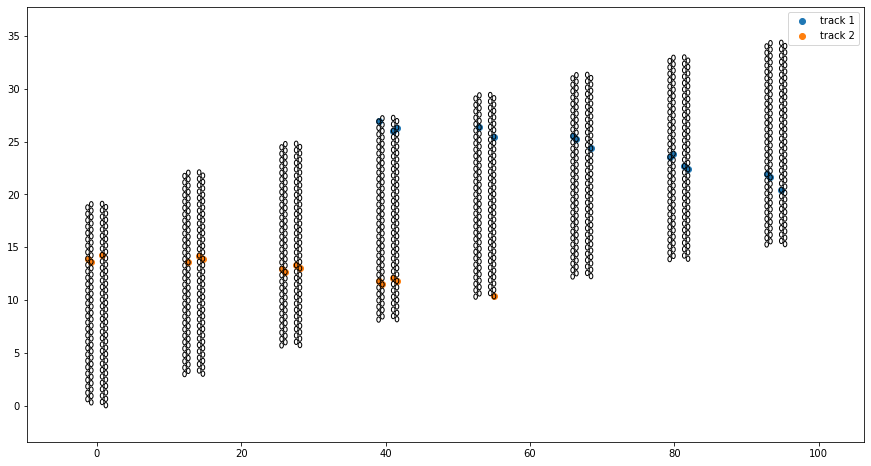


Model prediction:


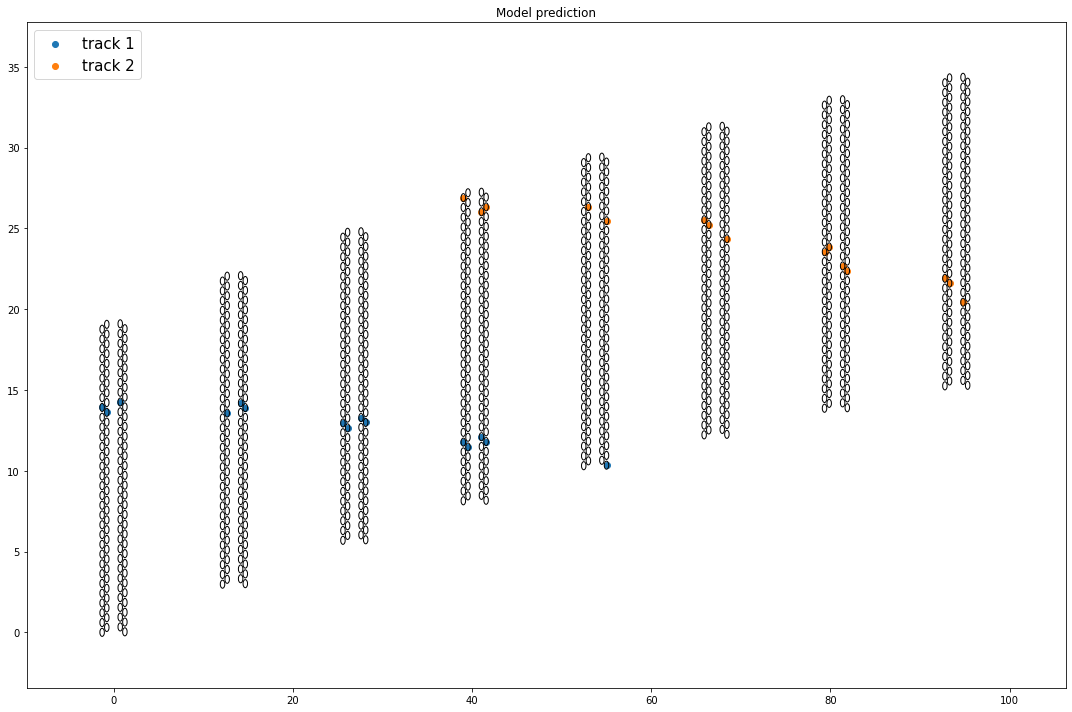

 Event # 7
Event truth:


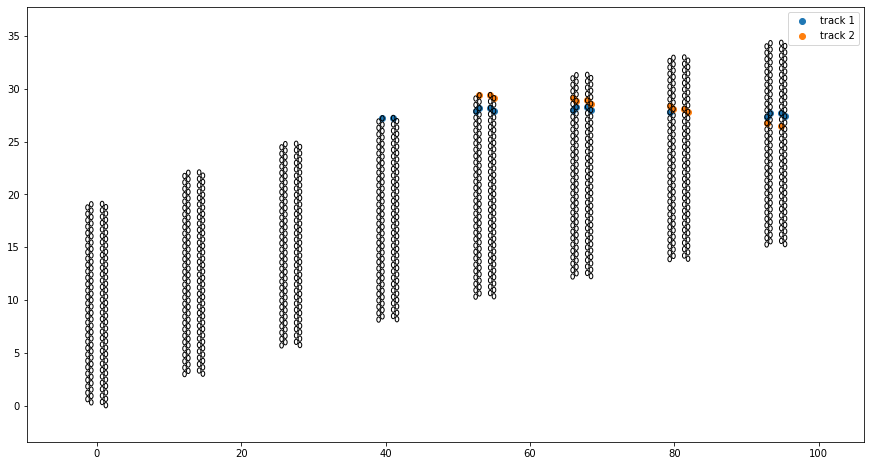

Skipping...


In [56]:
range_start=3
for i in range(range_start,range_start+5):
    print(' Event #', i)
    plot_event_and_prediction(evts_hits_valid[i], evts_ids_valid[i], figsize=(15,10))

## Build scoring function


In [58]:
def score_function(true_ids, predicted_ids):
    '''
    Calculate an accuracy score based on hits within events, which belong to seeded tracks.
    Both true and predicted ids are of shape (n_evts, length, width).
    Accuracy score is calculated as the fraction of correctly assigned hits.
    '''
    n_trackhits, n_trackhits_correct=0,0
    n_predicted,n_predicted_correct=0,0
    
    n_evts=true_ids.shape[0]
    n_print=max(1,int(n_evts/10))
    for i_evt in range(n_evts):
        if (i_evt%n_print)==0:
            print('scoring event #%d'%i_evt)
        
        ## get all true track ids in this event
        track_ids = [i for i in np.unique(true_ids[i_evt]) if i>0]
        if len(track_ids)==0: continue
        ## get all predicted ids in this event
        pred_ids = [i for i in np.unique(predicted_ids[i_evt]) if i>0]
        
        for pred_id in pred_ids:
            # get all hits that are predicted to be in the same track
            pred_layers,pred_straws=np.where(predicted_ids[i_evt]==pred_id)
            n_predicted += len(pred_layers)
            
            # get the real track that corresponds to this (ambiguity?)
            trackhit_ids, counts = np.unique(true_ids[i_evt][pred_layers,pred_straws], return_counts=True)
            most_id=np.argmax(counts)
            track_id = trackhit_ids[most_id]
            
            ''' ** Alt way to get track_id: **
            track_id=0
            for idx in track_ids:
                layers,straws=np.where(true_ids[i_evt]==idx)
                n_hits=len(layers)
                if np.sum(predicted_ids[i_evt][layers,straws])>(n_hits/2.):
                    n_trackhits+=n_hits
                    track_id=idx
                    break
            '''
            
            # get how many of the predicted_ids are correct:
            n_predicted_correct += len( np.where( true_ids[i_evt][pred_layers,pred_straws]==track_id )[0] )
            
            ## Hits in the real track:
            layers,straws=np.where(true_ids[i_evt]==track_id)
            n_trackhits += len(layers)
            
            # how many of these are predicted correctly
            n_trackhits_correct += len( np.where( predicted_ids[i_evt][layers,straws]==pred_id )[0] )
                
                
    if n_trackhits==0:
        print('No tracks found in events passed')
        return 0
    if n_predicted==0:
        print('No predicted tracks found in events passed')
        return 0

    
    print('Fraction of track hits identified correctly: ', n_trackhits_correct/n_trackhits)
    print('Fractional error (wrongly assigned hits): ', 1-n_predicted_correct/n_predicted)
    return n_predicted_correct/n_predicted



In [61]:
start_time = time.time()

predicted_ids=predict_events(evts_hits_valid[1000:])
score_function(evts_ids_valid[1000:], predicted_ids )

end_time = time.time()
print('time: ', end_time - start_time)

n_tracks=0
for predicted_id in predicted_ids:
    n_tracks += np.max(predicted_id)
print('Total tracks found: ', n_tracks)

predicting event #0
predicting event #263
predicting event #526
predicting event #789
predicting event #1052
predicting event #1315
predicting event #1578
predicting event #1841
predicting event #2104
predicting event #2367
predicting event #2630
scoring event #0
scoring event #263
scoring event #526
scoring event #789
scoring event #1052
scoring event #1315
scoring event #1578
scoring event #1841
scoring event #2104
scoring event #2367
scoring event #2630
Fraction of track hits identified correctly:  0.9463253195374315
Fractional error (wrongly assigned hits):  0.016382423491578146
time:  1123.4542758464813
Total tracks found:  4869.0


In [62]:
len(predicted_ids)

2634

* With quick training: 0.937  
* With pre-trained: 0.75  
    * about the same with the real straw locations  
* Pre-trained, with extra training: 0.956
* Most accurate : 0.905

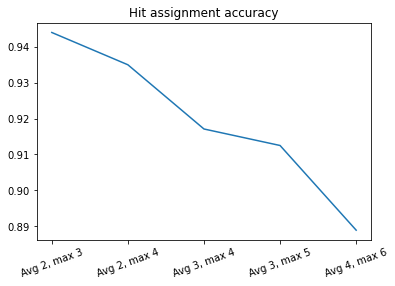

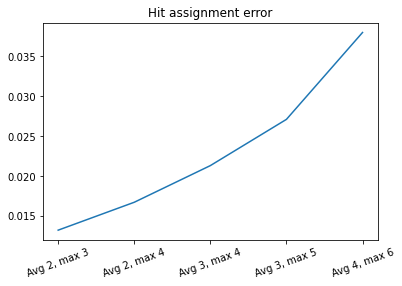

In [125]:
labels=['Avg 2, max 3', 'Avg 2, max 4',  'Avg 3, max 4', 'Avg 3, max 5', 'Avg 4, max 6']

full_acc  = [0.944,0.935,0.9171,0.9125,0.8889]
full_err  = [0.0132,0.0167,0.0213,0.0271,0.038]

plt.plot(full_acc)
plt.title('Hit assignment accuracy')
plt.xticks(np.arange(5), labels, rotation=20)  # Set text labels and properties.
plt.show()
plt.plot(full_err)
plt.title('Hit assignment error')
plt.xticks(np.arange(5), labels, rotation=20)  # Set text labels and properties.
plt.show()

## Notes on current status

The LSTM-based NN does pretty good with the realistic geometry and some difficult events in the dataset.

### Issues
Still some issues, some events are not perfect in ways that look improvable.  
* Difficulties arise when tracks are superimposed and close to each other. At that point both the seed-based searches for thesse tracks have not great results, and the seed merging algorithm is having troubles.
* Difficulties for some reason near the edge of the detector. Connection between successive modules can be lost, resulting in a shorter track candidate that is missing some modules, even when there are no other tracks in the event. 
* It is a little more difficult to get a good prediction from seeds that are later in the detector and need to be extrapolated backwards.

### Improvements needed
1) Add seeds as categorical variable. There are still a few cases where the seed hits are not selected, in difficult cases.
2) Prepare to add another feature variable for hit time. That should add more discrimination in high occupancy, and better track separation overall.
3) Improve training by adding weights to events according to their number of hits.
4) Add extra NN, each specializing in seeds from beginning/middle/end of the detector. That should improve performance for seeds late in the detector.

In [ ]:
'''
as used in the HEPTrkX

## prepare training input and labels
train_events = np.zeros((n_training_events, 1, det.length, det.width))
train_targets = -99 * np.ones((n_training_events, det.length, det.width))
train_weights = np.zeros((n_training_events, det.length, det.width))

for i_event in range(n_training_events):
    train_events[i_event,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
    event_targets = np.asarray(targets[:num_tracks])
    train_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
    train_weights[n,:num_tracks] = np.ones((num_tracks))
'''



In [ ]:

'''
def build_model_1():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=events_hits[0].shape)
    layer = layers.Convolution1D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution1D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    #layer = layers.MaxPooling2D(pool_size=(2,2))(layer) ## no pooling layers - they will reduce the dimension
    layer = layers.Convolution1D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution1D(32, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(mean_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    outputs = layers.Dense(original_dim, activation="sigmoid")(x)

    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

model = Sequential()
model.add(Conv1D(64, 
                 kernel_size=3, 
                 activation="relu", 
                 padding='same',
                 input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Conv1D(32, 
                 kernel_size=3, 
                 activation="relu",
                 padding='same'))
'''

### Test layers

In [20]:
conv_layer_input = Conv1D(40, kernel_size=3, 
                          activation='relu',
                          padding='same',
                          input_shape=events_hits[0].shape ) (events_hits)
conv_layer_input.shape

TensorShape([48663, 30, 40])

In [25]:
from keras.layers import Activation
activation=Activation('relu')(conv_layer_input)
activation.shape

TensorShape([48663, 30, 40])

In [30]:
from keras.layers import MaxPooling1D
maxpooling=MaxPooling1D(pool_size=2,strides=1,padding='same')(activation)
maxpooling.shape


TensorShape([48663, 30, 40])

In [295]:
conv_layer_middle = Conv1D(det.width, kernel_size=3, 
                          activation='relu',
                          padding='same' ) (conv_layer_input)
conv_layer_middle.shape

TensorShape([9745, 30, 50])

In [68]:
train_data_2D=np.asarray(events_hits)
dim1,dim2,dim3=train_data_2D.shape[:3]
train_data_2D=train_data_2D.reshape(dim1, dim2, dim3,1)
input_shape=train_data_2D.shape

conv2D_layer_input = Conv2D(40, kernel_size=(3,3), 
                          activation='relu',
                          padding='same',
                          input_shape=input_shape ) (train_data_2D)
conv2D_layer_input.shape

TensorShape([48663, 30, 50, 40])